# EveryBeam MWA integration tests

Goes without saying, but the test here rely on `WODEN` being compiled with `Everybeam` support. First import some code, and up some observational parameters. 

In [1]:
import os
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
from wodenpy.primary_beam.use_everybeam import run_everybeam, run_everybeam_over_threads
import erfa
import mwa_hyperbeam
from wodenpy.use_libwoden.create_woden_struct_classes import Woden_Struct_Classes
from ctypes import c_double
from astropy.time import TimeDelta
from wodenpy.array_layout.precession import RTS_Precess_LST_Lat_to_J2000

import sys
# sys.path.append('../../scripts/')
# from run_woden import main as run_woden

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

C = c.to('m/s').value

# ra0 = 0.0
# dec0 = -26.7
MWA_LAT=-26.703319405555554
MWA_LONG=116.67081523611111

##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T20:13:00"
##Assume that the OSKAR telescope is near the MWA??
mwa_location = EarthLocation(lat=MWA_LAT*u.deg, 
                            lon=MWA_LONG*u.deg,
                            height=377.827)
observing_time = Time(date, scale='utc', location=mwa_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg")#, RA: {ra0}")

print(observing_time.mjd*86400)

LST: 0.0045520088542088475 deg
5228309580.0


## What does the beam look like on the sky?

First up, let's plot the `hyperbeam` `MWA_FEE` beam model on the sky to see what we're expecting. `WODEN` likes the beam to be in IAU ordering, where the first (often called `x`) polarisation is aligned north-south. We also want this the have parallactic rotation, so switch that one. We'll use `hyperbeam` first, which we already use and have tested extensively within `WODEN`.

Note that we precess the array and LST back to J2000; this is how `WODEN` works internally to make everything happen in the J2000 frame. I'm doing it here explicitly to check the beam works in J2000.

/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


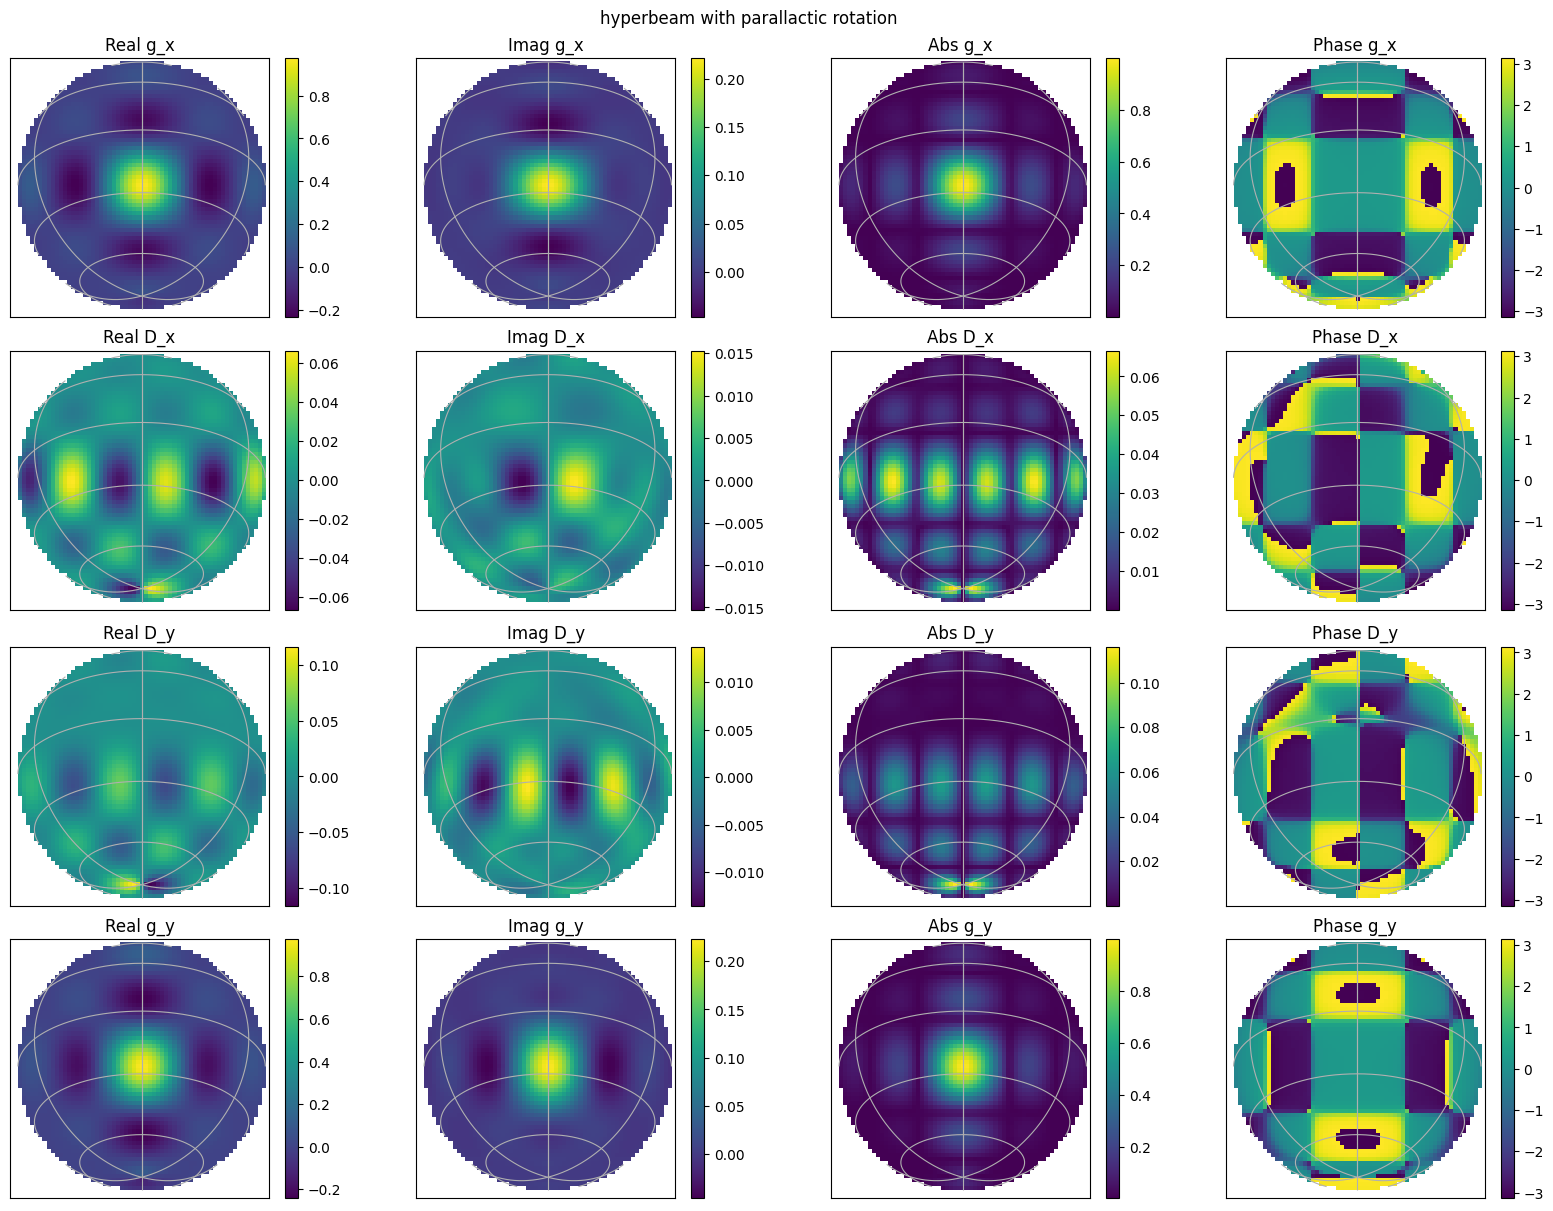

In [2]:
##Set up a grid of RA, Dec points

ra0 = LST_deg
dec0 = MWA_LAT

mjd_current = observing_time.mjd


lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(np.radians(LST_deg),
                                                         np.radians(MWA_LAT),
                                                         mjd_current)


nside=64
radec_reso=120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

##Then use erfa to convert these values into azs, els
# has = np.radians(LST_deg) - ras
has = lst_J2000 - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(has, decs, latitude_J2000)
za_grid = np.pi/2 - els

##mwa hyperbeam
beam = mwa_hyperbeam.FEEBeam(hdf5_file=os.environ["MWA_FEE_HDF5"])

freq = 180e+6

parallactic_rotation = True
IAU_order = True

jones = beam.calc_jones_array(az_grid, za_grid, freq, [0]*16, [1]*16,
                              IAU_order, latitude_J2000, parallactic_rotation)

all_gx_hyp = jones[:,0]
all_Dx_hyp = jones[:,1]
all_Dy_hyp = jones[:,2]
all_gy_hyp = jones[:,3]

all_gx_hyp.shape = (nside, nside)
all_Dx_hyp.shape = (nside, nside)
all_Dy_hyp.shape = (nside, nside)
all_gy_hyp.shape = (nside, nside)

plot_jones_on_sky(all_gx_hyp, all_Dx_hyp, all_Dy_hyp, all_gy_hyp, wcs, title="hyperbeam with parallactic rotation")

Do a sanity check that we have polarisations in the order that we want. North dipoles are most sensitive towards the East-West, so if we subtract Y from X, we should see a positive signal towards the East-West, and negative towards the North-South.

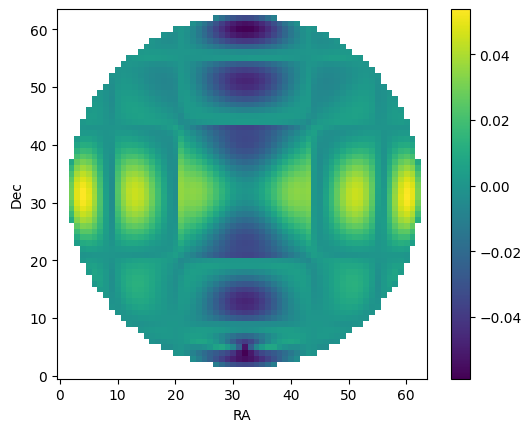

In [3]:
diff = np.abs(all_gx_hyp) - np.abs(all_gy_hyp)
im = plt.imshow(diff, origin='lower')
plt.colorbar(im)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

Aight, cool, we have a sensible beam patter benchmark to compare against.

## EveryBeam MWA
Let's now do the same with `everybeam` `MWA` and see how it compares. We'll use the `wodenpy.use_everybeam.run_everybeam` function to do this, which is what the `wodenpy` sky model reading code uses. However, it's a fairly slow function, so we'll run it in parallel over a number of cores. To do this, we'll use the helper function `wodenpy.use_everybeam.run_everybeam_over_threads`. This uses the same technique that `run_woden.py` uses to parallelise the sky model/beam calculations.

Thread 0 processing coords 0 to 512Thread 1 processing coords 512 to 1024Thread 2 processing coords 1024 to 1536Thread 4 processing coords 2048 to 2560Thread 3 processing coords 1536 to 2048

Thread 6 processing coords 3072 to 3584Thread 5 processing coords 2560 to 3072Thread 7 processing coords 3584 to 4096







/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:180

Thread 5 finishedThread 3 finished

Thread 7 finished
Thread 0 finished
Thread 1 finished
Thread 6 finished
Thread 2 finished
Thread 4 finished


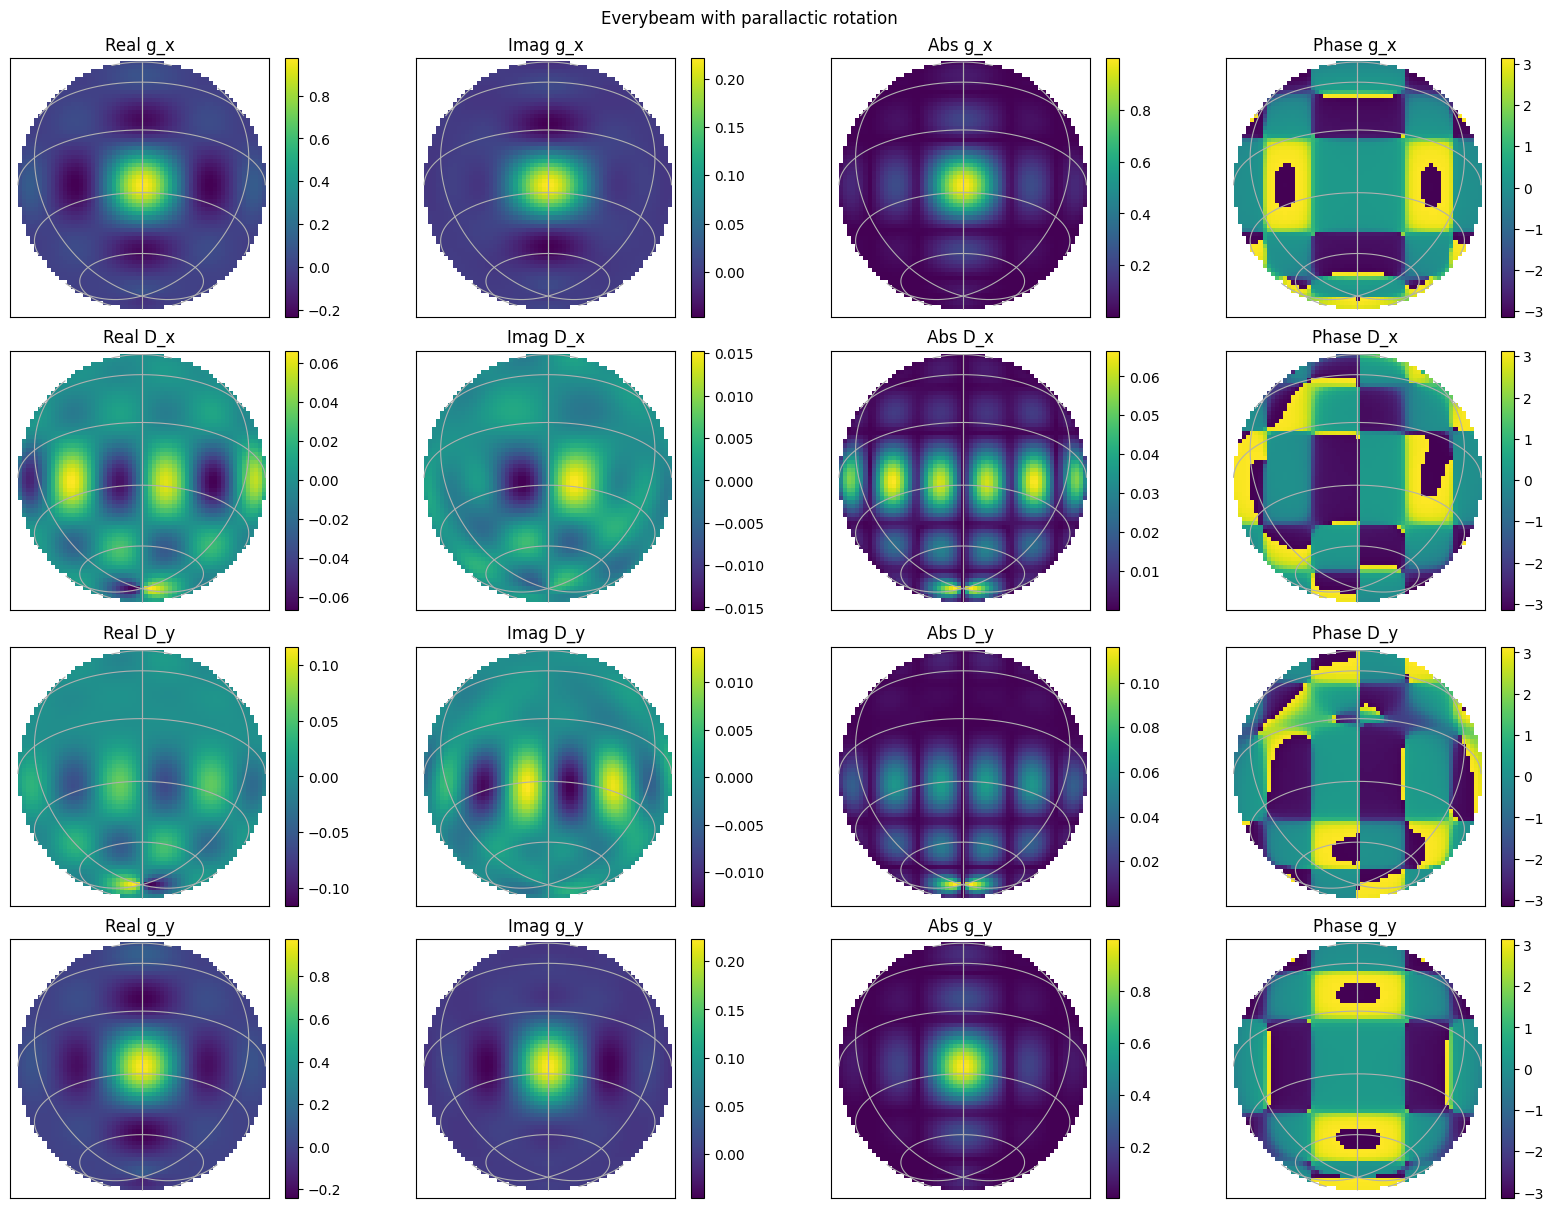

In [4]:
##Example MWA MS from the EveryBeam package
ms_path="MWA-single-timeslot.ms"
coeff_path=os.environ["MWA_FEE_HDF5"]
station_id = 0
station_ids = [0]
j2000_latitudes = [latitude_J2000]
j2000_lsts = [lst_J2000]
times = [observing_time]
freqs = [freq]
current_latitude = np.radians(MWA_LAT)
current_longitude = np.radians(MWA_LONG)

##The MWA everybeam model seems to pop out normalised beams
apply_beam_norms=False
use_differential_beam=False

##We need to turn on parallactic rotation in wodenpy as it doesn't exist for
##EveryBeam MWA. We also need to reorder the jones to get north-south first
parallactic_rotate=True
iau_order=True

##How many cores to split the work over
num_threads=8

all_jones = run_everybeam_over_threads(num_threads, ms_path,
                            coeff_path,
                            ras, decs,
                            np.radians(ra0), np.radians(dec0),
                            j2000_latitudes, j2000_lsts,
                            times, freqs, station_ids,
                            element_response_model='MWA',
                            apply_beam_norms=apply_beam_norms,
                            iau_order=iau_order,
                            parallactic_rotate=parallactic_rotate,
                            use_local_mwa=True)

beam_ind, time_ind, freq_ind = 0, 0, 0

all_gx_eb = all_jones[beam_ind, time_ind, freq_ind, :, 0, 0]
all_Dx_eb = all_jones[beam_ind, time_ind, freq_ind, :, 0, 1]
all_Dy_eb = all_jones[beam_ind, time_ind, freq_ind, :, 1, 0]
all_gy_eb = all_jones[beam_ind, time_ind, freq_ind, :, 1, 1]

all_gx_eb.shape = (nside, nside)
all_Dx_eb.shape = (nside, nside)
all_Dy_eb.shape = (nside, nside)
all_gy_eb.shape = (nside, nside)

plot_jones_on_sky(all_gx_eb, all_Dx_eb, all_Dy_eb, all_gy_eb, wcs, 'Everybeam with parallactic rotation')

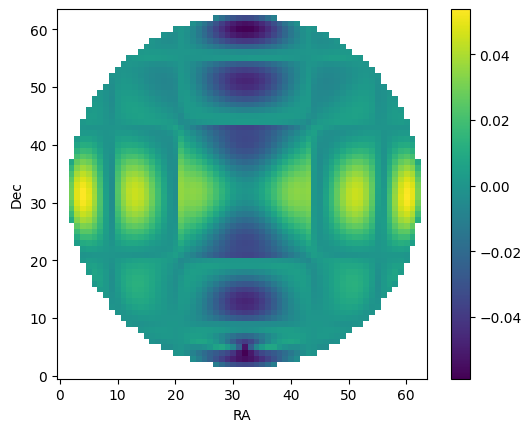

In [5]:
diff = np.abs(all_gx_eb) - np.abs(all_gy_eb)
im = plt.imshow(diff, origin='lower')
plt.colorbar(im)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.show()

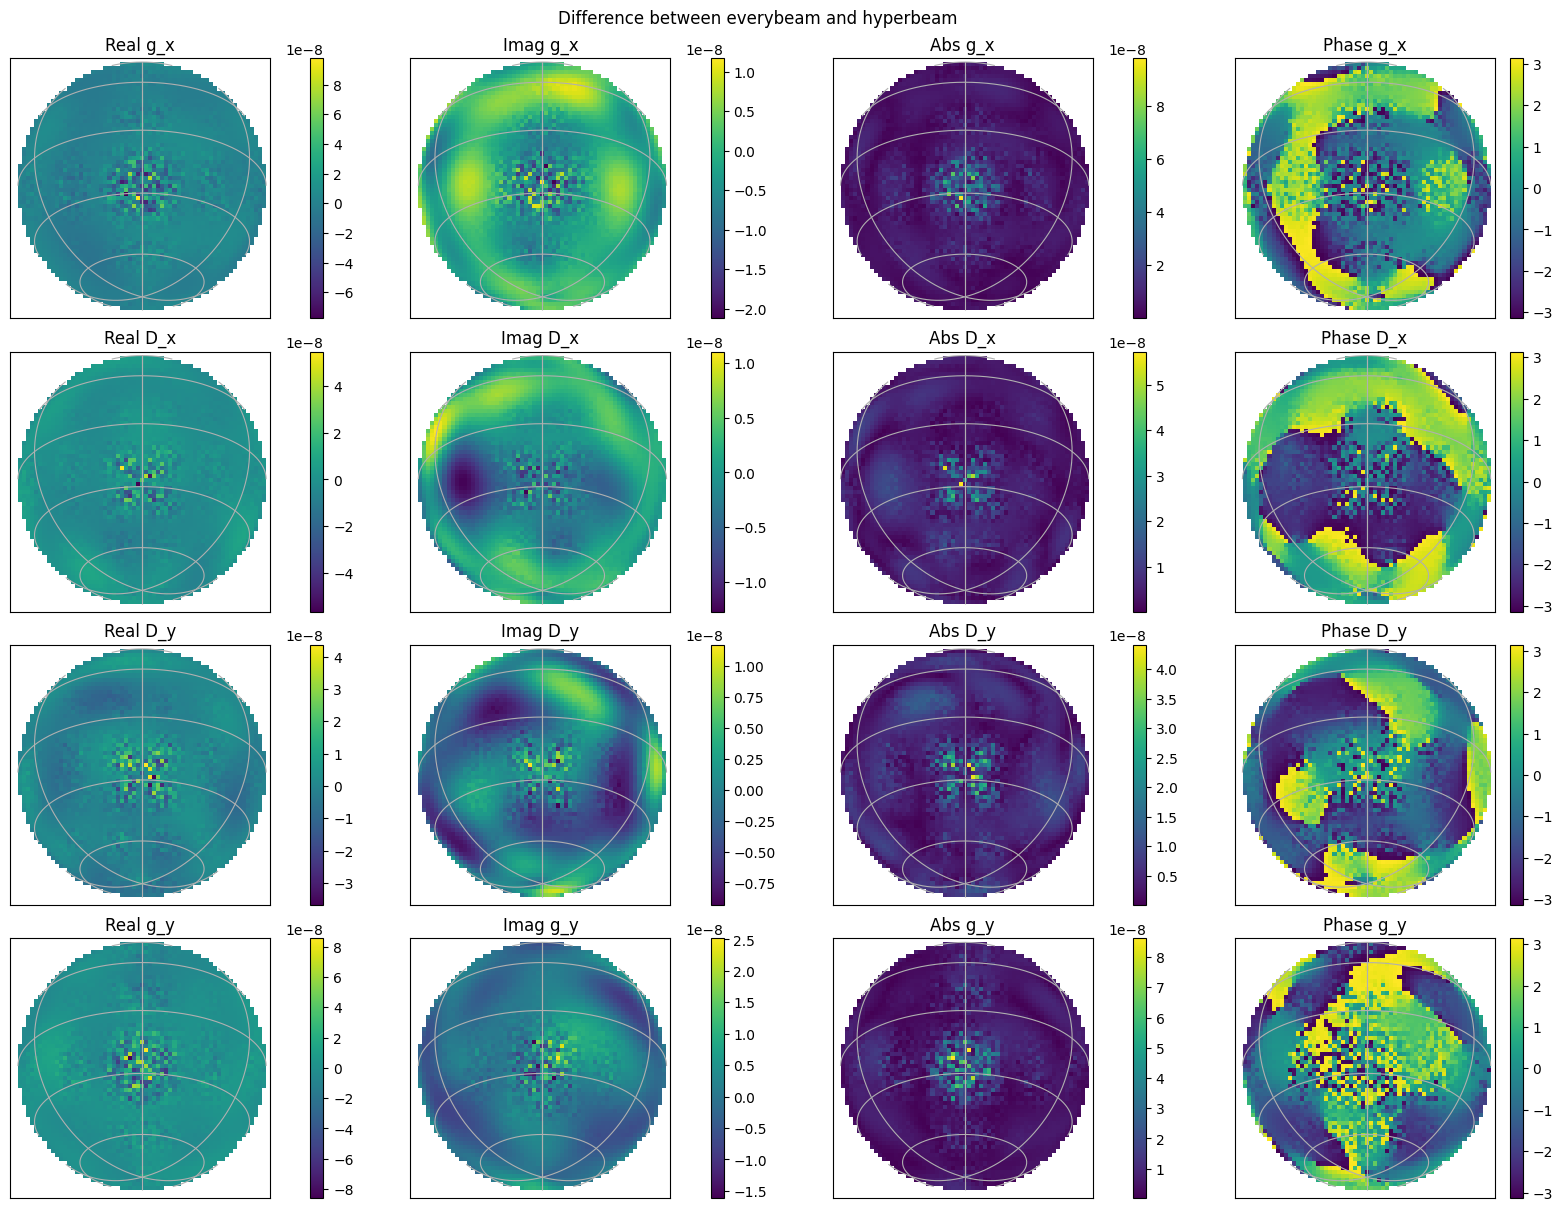

In [6]:
diff_gx = all_gx_eb - all_gx_hyp
diff_Dx = all_Dx_eb - all_Dx_hyp
diff_Dy = all_Dy_eb - all_Dy_hyp
diff_gy = all_gy_eb - all_gy_hyp

plot_jones_on_sky(diff_gx, diff_Dx, diff_Dy, diff_gy, wcs, 'Difference between everybeam and hyperbeam')

Lovely. Things are looking extremely similar, which is great.

## Stokes recovery
Now let's check that we can recover the Stokes parameters from the beam. We'll just test a single point source at zenith, where the gains should essentially be 1.0 and leakage zero. We'll run all Stokes of I, Q, U, V through the full simulator, recombine the linear polarisations, and check we get back what we put in.

First, make our sky models. We'll make 4 Stokes I models, where each has either I, Q, U, V = 1, and all other Stokes are zero. To make that happen for Q/U, make the component a list type so explicitly set one or the other to zero.

In [7]:
make_sky_models(ra0, dec0)

Keep the simulations tiny by making a 3 ant array

In [8]:
np.random.seed(234987)

##make a random array layout. Source is at phase centre, so the visibilities
##should all be full real and just be set by the flux in the sky
num_antennas = 3
east = np.random.uniform(-1000, 1000, num_antennas)
north = np.random.uniform(-1000, 1000, num_antennas)
height = np.zeros(num_antennas)

array = np.empty((num_antennas, 3))
array[:,0] = east
array[:,1] = north
array[:,2] = height

array_name = "eg_array.txt"
np.savetxt(array_name, array)

Run the 4 different Stokes sky models through `hyperbeam` first as a point of comparison. We're avoiding using metafits here to be as apples to apples with `EveryBeam` as possible.


In [9]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "MWA_FEE"

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'

    cmd = 'run_woden.py '

    cmd += f'--ra0={ra0} '
    cmd += f'--dec0={dec0} '
    cmd += f'--array_layout={array_name} '
    cmd += f'--date={date} '
    cmd += f'--output_uvfits_prepend={uvfits_name} '
    cmd += f'--primary_beam={primary_beam} '
    cmd += f'--freq_res={freq_reso} '
    cmd += f'--band_nums=1 '
    cmd += f'--num_time_steps=1 '
    cmd += f'--IAU_order '
    cmd += f'--cat_filename={cat_name} '
    cmd += f'--lowest_channel_freq={low_freq} '
    cmd += f'--num_freq_channels={num_freq_chans} '
    cmd += f'--time_res=2 '
    cmd += f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] '
    cmd += f'--num_threads=1 '
    
    call(cmd, shell=True)

      

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-02-27 09:49:03 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:03 - INFO - Input arguments after parsing:
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
                             	Array central height: 377.827 m
                    

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-02-27 09:49:05 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:05 - INFO - Input arguments after parsing:
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
                             	Array central height: 377.827 m
                    

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-02-27 09:49:07 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:07 - INFO - Input arguments after parsing:
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
                             	Array central height: 377.827 m
                    

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-02-27 09:49:10 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:10 - INFO - Input arguments after parsing:
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
                             	Array central height: 377.827 m
                    

Tests are defined in `eb_testing_code.py`, which just asserts that whichever Stokes param we set to one comes out as one, and everything else is zero. Make the absolute tolerance of the test something to toggle, because real beam has leakage, and we don't have the beam at exactly the phase centre for `hyperbeam`. The Stokes recovery is only really legit when the XX and YY beams are the same, so it's good at phase centre and zenith.

Do the actual tests for MWA FEE beam

In [10]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'MWA_FEE', atol=5e-3)


Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


Right, try and do the same thing with `EveryBeam`

In [11]:
##parameters for the simulation; setting the date sets an LST of about 0 deg
##to match the phase centre

freq_reso = 1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_MWA"

# print("WHAT DIS", os.environ["MWA_FEE_HDF5"])

for pol in ['I', 'Q', 'U', 'V']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    cmd = 'run_woden.py '

    cmd += f'--ra0={ra0} '
    cmd += f'--dec0={dec0} '
    cmd += f'--array_layout={array_name} '
    cmd += f'--date={date} '
    cmd += f'--output_uvfits_prepend={uvfits_name} '
    cmd += f'--primary_beam={primary_beam} '
    cmd += f'--beam_ms_path={ms_path} '
    cmd += f'--station_id=0 '
    cmd += f'--freq_res={freq_reso} '
    cmd += f'--band_nums=1 '
    cmd += f'--num_time_steps=1 '
    cmd += f'--IAU_order '
    cmd += f'--cat_filename={cat_name} '
    cmd += f'--lowest_channel_freq={low_freq} '
    cmd += f'--num_freq_channels={num_freq_chans} '
    cmd += f'--time_res=2 '
    
    cmd += f'--num_threads=1 '
    
    call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table MWA-single-timeslot.ms: 24 columns, 2628 rows
Successful readonly open of default-locked table MWA-single-timeslot.ms/SPECTRAL_WINDOW: 15 columns, 1 rows
2025-02-27 09:49:12 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:12 - INFO - Input arguments after parsing:
            

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table MWA-single-timeslot.ms: 24 columns, 2628 rows
Successful readonly open of default-locked table MWA-single-timeslot.ms/SPECTRAL_WINDOW: 15 columns, 1 rows
2025-02-27 09:49:14 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:14 - INFO - Input arguments after parsing:
            

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table MWA-single-timeslot.ms: 24 columns, 2628 rows
Successful readonly open of default-locked table MWA-single-timeslot.ms/SPECTRAL_WINDOW: 15 columns, 1 rows
2025-02-27 09:49:17 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:17 - INFO - Input arguments after parsing:
            

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table MWA-single-timeslot.ms: 24 columns, 2628 rows
Successful readonly open of default-locked table MWA-single-timeslot.ms/SPECTRAL_WINDOW: 15 columns, 1 rows
2025-02-27 09:49:19 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:19 - INFO - Input arguments after parsing:
            

In [12]:
for pol in ['I', 'Q', 'U', 'V']:
    test_stokes_recovery(pol, 'everybeam_MWA', atol=5e-3)
    
    # #Uncomment to print out example values
    # uvfits_name = f"stokes{pol}_everybeam_MWA"
    # XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    # ##pick a random baseline to plot, they should all be the sam
    # baseline = 0

    # recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    # print(f"{pol}, {recover_I[0].real:.2f}, {recover_Q[0].real:.2f}, {recover_U[0].real:.2f}, {recover_V[0].real:.2f}")

Testing Stokes I
Stokes I passed
Testing Stokes Q
Stokes Q passed
Testing Stokes U
Stokes U passed
Testing Stokes V
Stokes V passed


## Now test an RM recovery
Check we recover the correct RM and sign for a linearly polarised source. First of all, make the sky model.

In [13]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

Run that through WODEN using `hyperbeam` to check the test is working.

In [14]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "MWA_FEE"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

cmd = 'run_woden.py '

cmd += f'--ra0={ra0} '
cmd += f'--dec0={dec0} '
cmd += f'--array_layout={array_name} '
cmd += f'--date={date} '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps=1 '
cmd += f'--IAU_order '
cmd += f'--cat_filename={cat_name} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] '
cmd += f'--num_threads=1 '


call(cmd, shell=True)    

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-02-27 09:49:21 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:21 - INFO - Input arguments after parsing:
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
                             	Array central height: 377.827 m
                    

0

Have a look and check our visis make sense

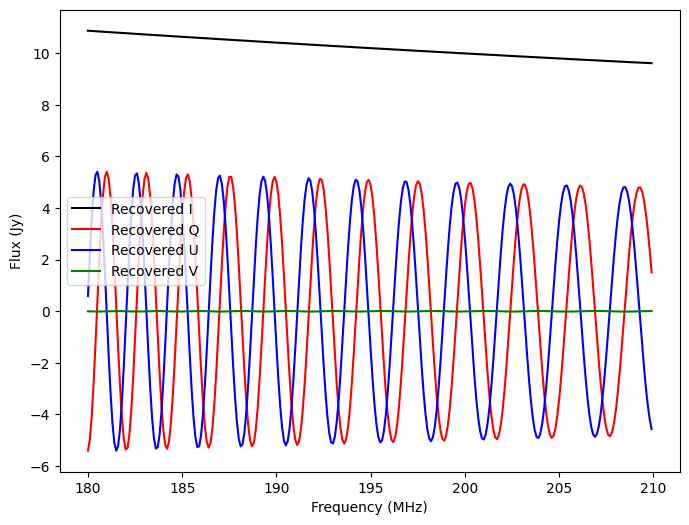

In [15]:
XX, XY, YX, YY = read_uvfits('rm_source_MWA_FEE_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

# fig, axs = plt.subplots(1, 1, figsize=(8, 6))
# axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Polarisation Fraction')

Now define a test, using a bunch of Emil's RM synthesis code. 

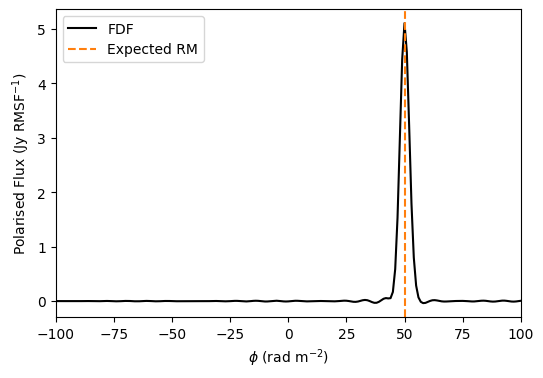

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999538 Expected Pol Fraction 0.5


In [16]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

Loverly, works a treat. Now let's do that with `EveryBeam`.

In [17]:
freq_reso = 0.1e+6
low_freq = 180e+6
high_freq = 210e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_MWA"
uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

cmd = 'run_woden.py '

cmd += f'--ra0={ra0} '
cmd += f'--dec0={dec0} '
cmd += f'--array_layout={array_name} '
cmd += f'--date={date} '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--beam_ms_path={ms_path} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps=1 '
cmd += f'--IAU_order '
cmd += f'--station_id=0 '
cmd += f'--cat_filename={cat_name} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--num_threads=1 '

call(cmd, shell=True)


/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table MWA-single-timeslot.ms: 24 columns, 2628 rows
Successful readonly open of default-locked table MWA-single-timeslot.ms/SPECTRAL_WINDOW: 15 columns, 1 rows
2025-02-27 09:49:24 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:24 - INFO - Input arguments after parsing:
            

0

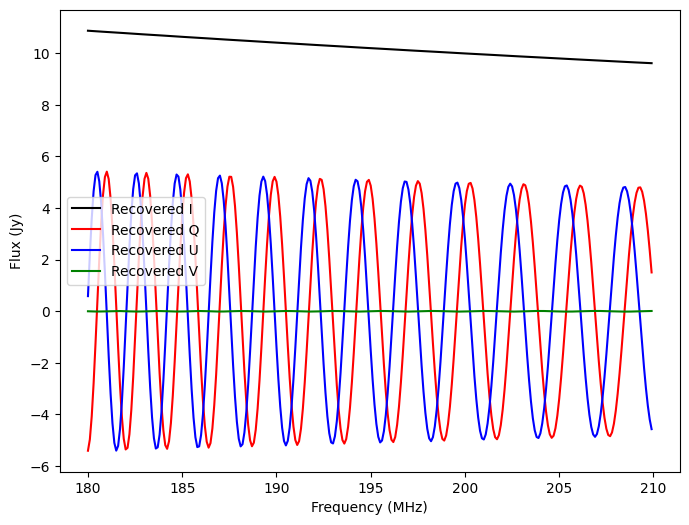

In [18]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_MWA_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

Looks good!

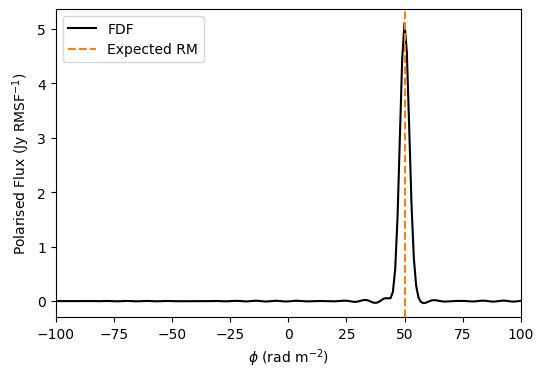

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999532 Expected Pol Fraction 0.5


In [19]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)

Yup works woot

## Test antenna locations

Now check to see if the antenna locations are read in correctly from a measurement set. We'll run `WODEN` using the a `metafits` file first, and then using a measurement set that came out of `hyperdrive` which is calibrated data that matches the observation of the `metafits`. Hopefully they match up.

In [20]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)
ra0 = 60.0
date = "2015-09-10T19:44:15"

freq_reso = 0.1e+6
low_freq = 180e+6
num_freq_chans = 1

primary_beam = "MWA_FEE"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

cmd = 'run_woden.py '

cmd += f'--ra0={ra0} '
cmd += f'--dec0={dec0} '
cmd += f'--date={date} '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--metafits_filename=../../examples/metafits/1125949472_metafits.fits '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps=1 '
cmd += f'--IAU_order '
cmd += f'--cat_filename={cat_name} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--MWA_FEE_delays=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] '
cmd += f'--num_threads=1 '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


2025-02-27 09:49:27 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:27 - INFO - Input arguments after parsing:
                             	Array central latitude: -26.703 deg
                             	Array central longitude: 116.671 deg
                             	Array central height: 377.827 m
                    

0

In [21]:
primary_beam = "everybeam_MWA"

uvfits_name = f"ant_locs_{primary_beam}"
cat_name = 'RM_source.fits'

ms_path = '/home/jack-line/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms'


cmd = 'run_woden.py '

cmd += f'--ra0={ra0} '
cmd += f'--dec0={dec0} '
cmd += f'--date={date} '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--beam_ms_path={ms_path} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps=1 '
cmd += f'--IAU_order '
cmd += f'--station_id=0 '
cmd += f'--cat_filename={cat_name} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table /home/jack-line/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms: 23 columns, 115584 rows
Successful readonly open of default-locked table /home/jack-line/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms/SPECTRAL_WINDOW: 15 columns, 1 rows
Successful readonly open of default-locked table /home/jack-line/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms/ANTENNA: 13 columns, 128 rows
2025-02-27 09:49:29 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
    

0

Read in the XYZ positions from the resultant `uvfits` files, as well as the `uvw` coordinates.

In [22]:
def read_xyz_uvfits(uvfits_name):
    
    with fits.open(uvfits_name) as hdu:
        xyz = hdu[1].data['STABXYZ']
        uu = hdu[0].data['UU']*C
        vv = hdu[0].data['VV']*C
        ww = hdu[0].data['WW']*C
        
    return xyz, uu, vv, ww

In [23]:
xyz_meta, uu_meta, vv_meta, ww_meta = read_xyz_uvfits('ant_locs_MWA_FEE_band01.uvfits')
xyz_ms, uu_ms, vv_ms, ww_ms = read_xyz_uvfits('ant_locs_everybeam_MWA_band01.uvfits')

First up compare the XYZ coords

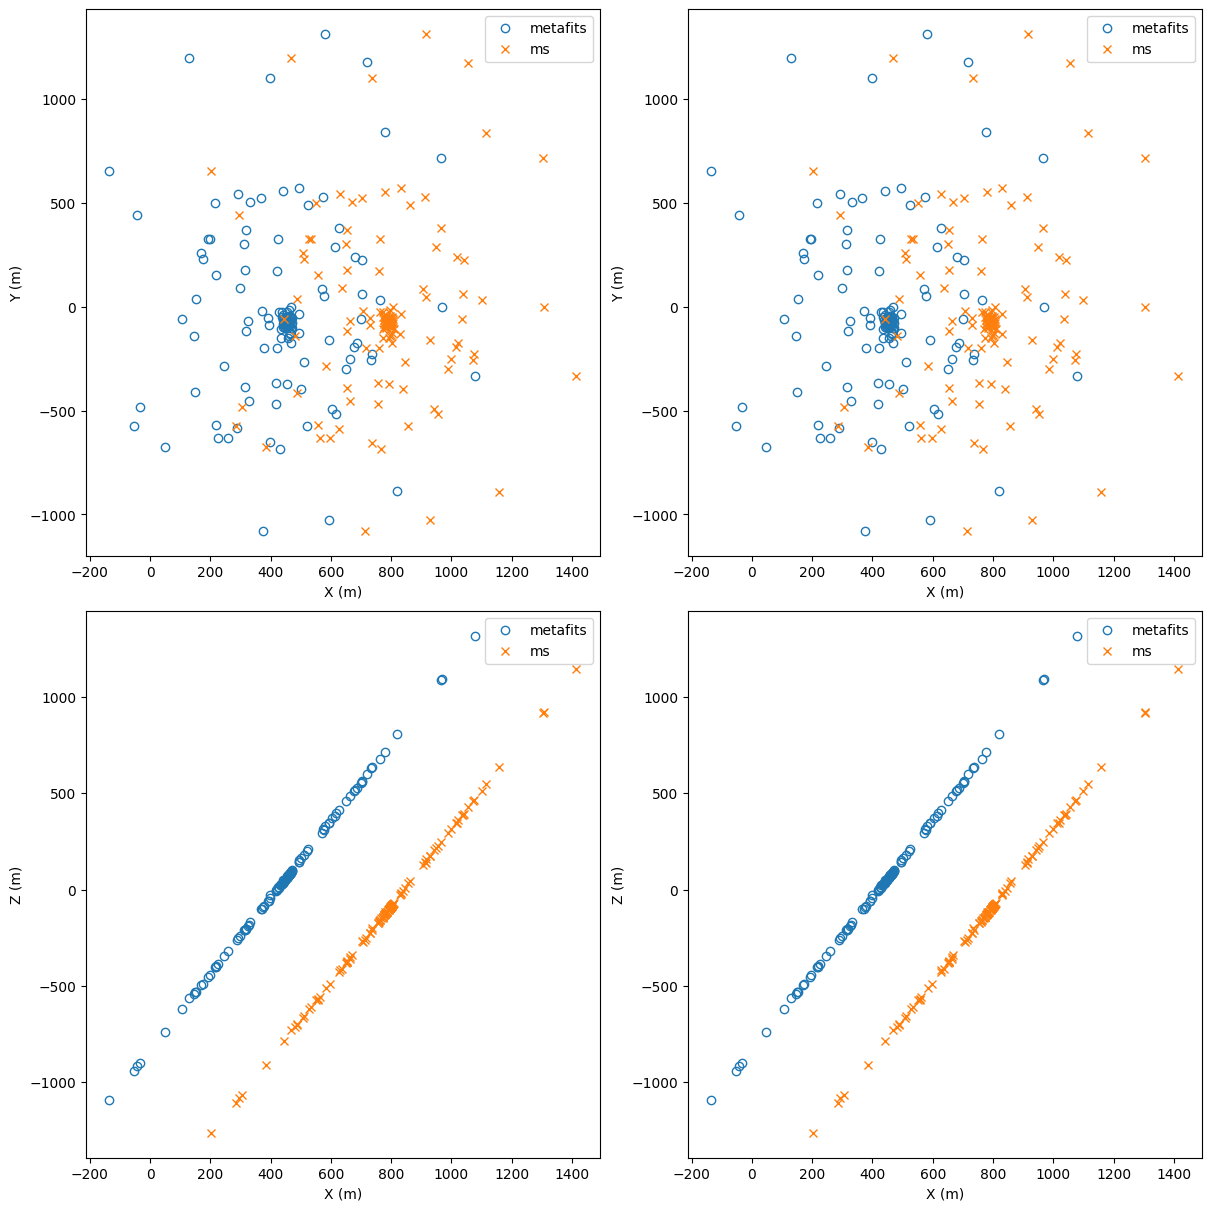

In [24]:
def plot(xyz, ax1, ax2, marker, label):
        
        ax1.plot(xyz[:,0], xyz[:,1], marker, mfc='none', label=label)
        ax2.plot(xyz[:,0], xyz[:,2], marker, mfc='none', label=label)
        
        
fig, axs = plt.subplots(2, 2, figsize=(12, 12), layout='constrained')

plot(xyz_meta, axs[0,0], axs[1,0], 'o', 'metafits')
plot(xyz_ms, axs[0,0], axs[1,0], 'x', 'ms')

plot(xyz_meta, axs[0,1], axs[1,1], 'o', 'metafits')
plot(xyz_ms, axs[0,1], axs[1,1], 'x', 'ms')

for ax in axs.flatten():
    ax.legend()
    
axs[0,0].set_xlabel('X (m)')
axs[0,0].set_ylabel('Y (m)')
axs[0,1].set_xlabel('X (m)')
axs[0,1].set_ylabel('Y (m)')

axs[1,0].set_xlabel('X (m)')
axs[1,0].set_ylabel('Z (m)')
axs[1,1].set_xlabel('X (m)')
axs[1,1].set_ylabel('Z (m)')

plt.show()

Ah bummer there is some kind of central positional shift in the XYZs. It is unclear if this is a `WODEN` or a `hyperdrive` issue. The layouts are exactly the same, just offset.

In [25]:
np.allclose(xyz_meta, xyz_ms, atol=1e-3, rtol=1e-6)


False

Now compare the `uv` coords. 

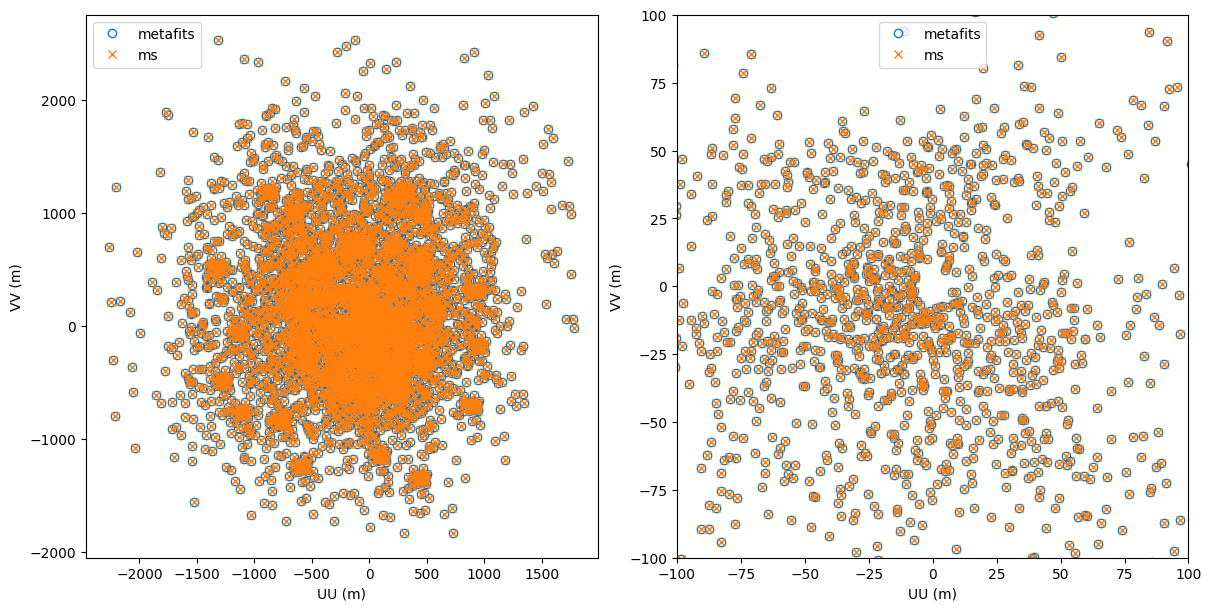

In [26]:
        
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')


for ax in axs:

    ax.plot(uu_meta, vv_meta, 'C0o', mfc='none', label='metafits')
    # ax.plot(-uu_meta, -vv_meta, 'C0o', mfc='none')

    ax.plot(uu_ms, vv_ms, 'C1x', mfc='none', label='ms')
    # ax.plot(-uu_ms, -vv_ms, 'C1x', mfc='none')
    
    ax.set_xlabel('UU (m)')
    ax.set_ylabel('VV (m)')
    
    ax.legend()
        
axs[1].set_xlim(-100, 100)
axs[1].set_ylim(-100, 100)

plt.show()

In [27]:
print(f"u coords max, mean diff {np.max(np.abs(uu_meta - uu_ms)):.2e}, {np.mean(np.abs(uu_meta - uu_ms)):.2e} (metres)")
print(f"v coords max, mean diff {np.max(np.abs(vv_meta - vv_ms)):.2e}, {np.mean(np.abs(vv_meta - vv_ms)):.2e} (metres)")
print(f"w coords max, mean diff {np.max(np.abs(ww_meta - ww_ms)):.2e}, {np.mean(np.abs(ww_meta - ww_ms)):.2e} (metres)")

u coords max, mean diff 8.79e-03, 3.11e-04 (metres)
v coords max, mean diff 8.01e-03, 2.91e-04 (metres)
w coords max, mean diff 2.32e-03, 9.60e-05 (metres)


The layout might be shifted, but the layout is pretty much indentical, as we end up with the same `uv` coordinates. So that's good.

## Test source positions
With the array offset seen, we need to check that the source positions are still coming out correctly. Make a simulation with a grid of sources, and check that the source positions are coming out correctly.

In [28]:
nside=5
half_width = 5

ra0 = 60.0
dec0 = -30.0

ras = np.linspace(ra0 - half_width, ra0 + half_width, nside)
decs = np.linspace(dec0 - half_width, dec0 + half_width, nside)

ras, decs = np.meshgrid(ras, decs)
ras, decs = ras.flatten(), decs.flatten()

num_comps = len(ras)

ras = ras.flatten()
decs = decs.flatten()

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.ones(num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

cat_name = 'check_positions.fits'

main_table.write(cat_name, format='fits', overwrite=True)

In [29]:
primary_beam = "everybeam_MWA"

uvfits_name = f"check_positions_{primary_beam}"
cat_name = 'check_positions.fits'

ms_path = '/home/jack-line/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms'

num_freq_chans = 10
freq_reso = 100e+3
low_freq = 150e+6

ra0 = 60.0
dec0 = -30.0

cmd = 'run_woden.py '

cmd += f'--ra0={ra0} '
cmd += f'--dec0={dec0} '
cmd += f'--metafits_filename=../../examples/metafits/1125949472_metafits.fits '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--beam_ms_path={ms_path} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps=5 '
cmd += f'--IAU_order '
cmd += f'--station_id=0 '
cmd += f'--cat_filename={cat_name} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table /home/jack-line/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms/ANTENNA: 13 columns, 128 rows
2025-02-27 09:49:33 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:49:33 - INFO - Input arguments after parsing:
                             	Array central latitude

0

In [30]:
cmd = "woden_uv2ms.py "
cmd += "  --uvfits_prepend=check_positions_everybeam_MWA_band "
cmd += "  --band_nums=1  "

call(cmd, shell=True)

cmd = "wsclean -name check_positions_everybeam_MWA -size 2048 2048 -niter 2000 "
cmd += "  -auto-threshold 0.5 -auto-mask 3 "
cmd += "  -pol I -multiscale -weight briggs 0 -scale 0.01 -j 12 -mgain 0.85 "
cmd += "  -no-update-model-required "
cmd += "  check_positions_everybeam_MWA_band*.ms "

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/woden_uv2ms.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')
The telescope frame is set to '????', which generally indicates ignorance. Defaulting the frame to 'itrs', but this may lead to other warnings or errors.
Writing in the MS file that the units of the data are uncalib, although some CASA process will ignore this and assume the units are all in Jy (or may not know how to handle data in these units).



WSClean version 3.4 (2023-10-11)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

No corrected data in first measurement set: tasks will be applied on the data column.
=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  I   0  0  0  0  0  0  150-151 (10)
Reordering check_positions_everybeam_MWA_band01.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0) weighting...
Opening reordered part 0 spw 0 for check_positions_everybeam_MWA_band01.ms
Detected 62.7 GB of system memory, usage not limited.
Opening reordered part 0 spw 0 for check_positions_everybeam_MWA_band01.ms
Determining min and max w & theoretical beam size... DONE (w=[6.6711e-05:337.434] lambdas, maxuvw=1446.37

0

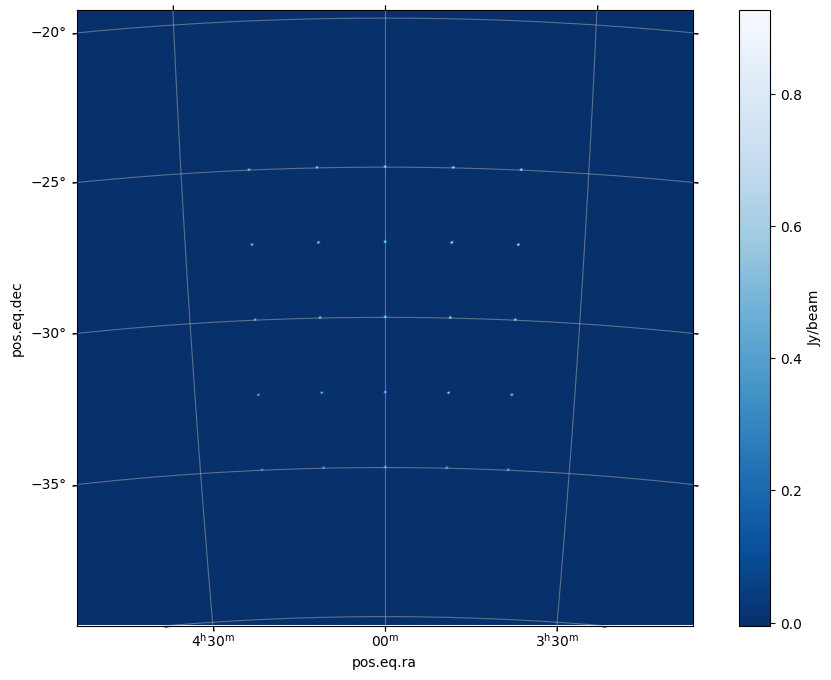

In [31]:
with fits.open('check_positions_everybeam_MWA-image.fits') as hdu:
    image = np.squeeze(hdu[0].data)
    wcs = WCS(hdu[0].header).celestial
    
fig, axs = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': wcs})

im = axs.imshow(image, origin='lower', cmap='Blues_r')#, vmin=0, vmax=1.0)
plt.colorbar(im, ax=axs, label='Jy/beam')

# half_width = 600

# axs.set_xlim(1024-half_width, 1024+half_width)
# axs.set_ylim(1024-half_width, 1024+half_width)

plt.grid(alpha=0.5)

plt.show()

Everything seems to be in the correct RA/Dec position, so that's schweet.

## Try off zenith pointings
Now we'll test whether we can do off-zenith pointings. We'll also test that we can run multiple time steps and frequencies. The measurement set I'm using is real calibrated data from the MWA. Unfortunately, it's 2GB, so there's no good way to include that with the `WODEN` repo. If you want to run this test, you should be able to get some data from the MWA ASVO https://asvo.mwatelescope.org/, and then convert that into a measurement set using `pyuvdata` for example.

In [32]:

ra0 = 60.0
dec0 = -30.0
date = "2015-09-10T19:44:15"
observing_time = Time(date, scale='utc', location=mwa_location)

##Setup a grid of RA/Dec on the sky
nside=50
radec_reso = 120/nside

header, wcs = create_WCS(ra0, dec0, nside, radec_reso)
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))
ras, decs = wcs.all_pix2world(x_mesh, y_mesh, 0)

ras = np.radians(ras.flatten())
decs = np.radians(decs.flatten())

num_comps = len(ras)

##Do a single freqs and time and beam
all_freqs = np.array([100e+6, 200e+6])
all_times = np.array([observing_time, observing_time + TimeDelta(2*3600.0, format='sec')])
num_beams = 1
station_ids = [0]

lsts = []
latitudes = []

for obs_time in all_times:
    
    LST = obs_time.sidereal_time('mean')
    lst_current = np.radians(LST.value*15)
    
    lst_J2000, latitude_J2000 = RTS_Precess_LST_Lat_to_J2000(
                                lst_current,
                                np.radians(MWA_LAT),
                                obs_time.mjd)
    
    lsts.append(lst_J2000)
    latitudes.append(latitude_J2000)

coeff_path= os.environ["MWA_FEE_HDF5"]
ms_path = '/home/jack-line/Dropbox/work/test_WODEN/everybeam/run_MWA_beam/hypcal_1125949472.ms'

apply_beam_norms = False
reorder_jones = True
parallactic_rotate = True

num_threads = 8

all_jones = run_everybeam_over_threads(num_threads, ms_path,
                            coeff_path,
                            ras, decs,
                            np.radians(ra0), np.radians(dec0),
                            latitudes, lsts,
                            all_times, all_freqs, station_ids,
                            apply_beam_norms=apply_beam_norms,
                            iau_order=iau_order,
                            parallactic_rotate=parallactic_rotate)

Thread 0 processing coords 0 to 313Thread 1 processing coords 313 to 626Thread 3 processing coords 939 to 1252Thread 2 processing coords 626 to 939Thread 5 processing coords 1565 to 1878
Thread 4 processing coords 1252 to 1565Thread 6 processing coords 1878 to 2191Thread 7 processing coords 2191 to 2504








/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:180

Thread 7 finished
Thread 6 finished
Thread 5 finished
Thread 4 finished
Thread 0 finished
Thread 1 finished
Thread 2 finished
Thread 3 finished


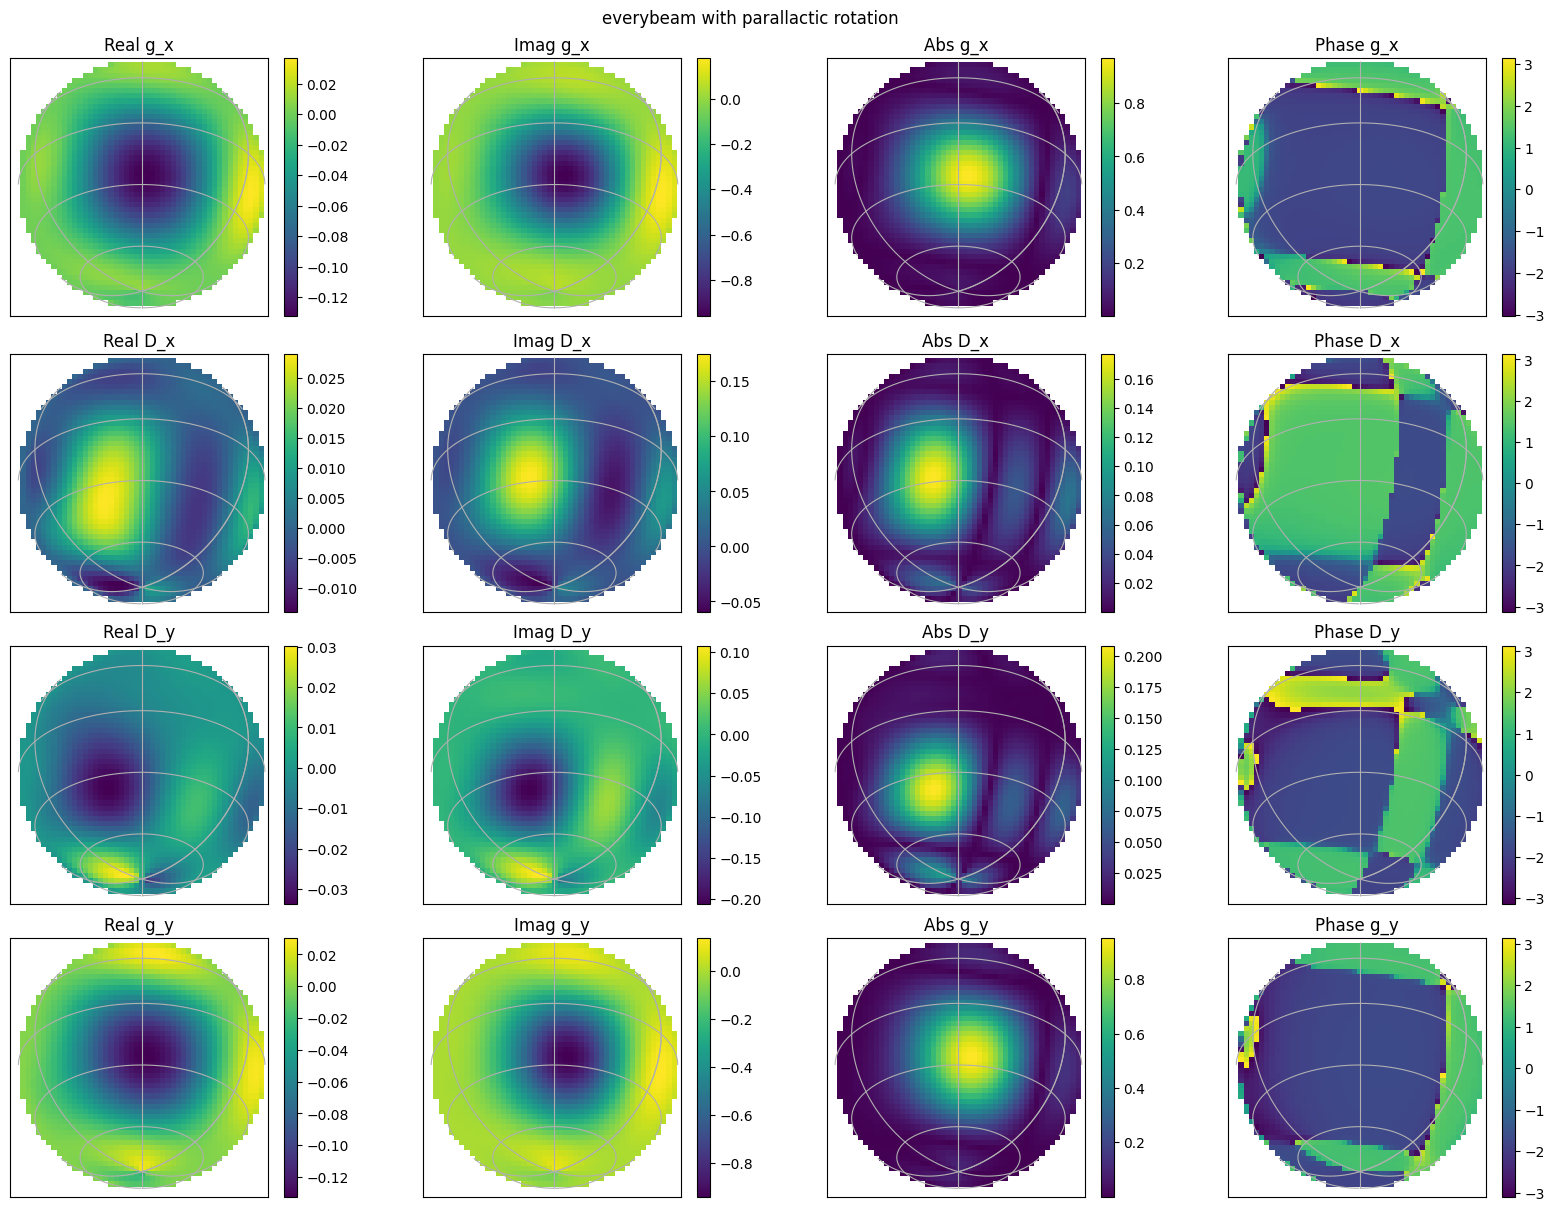

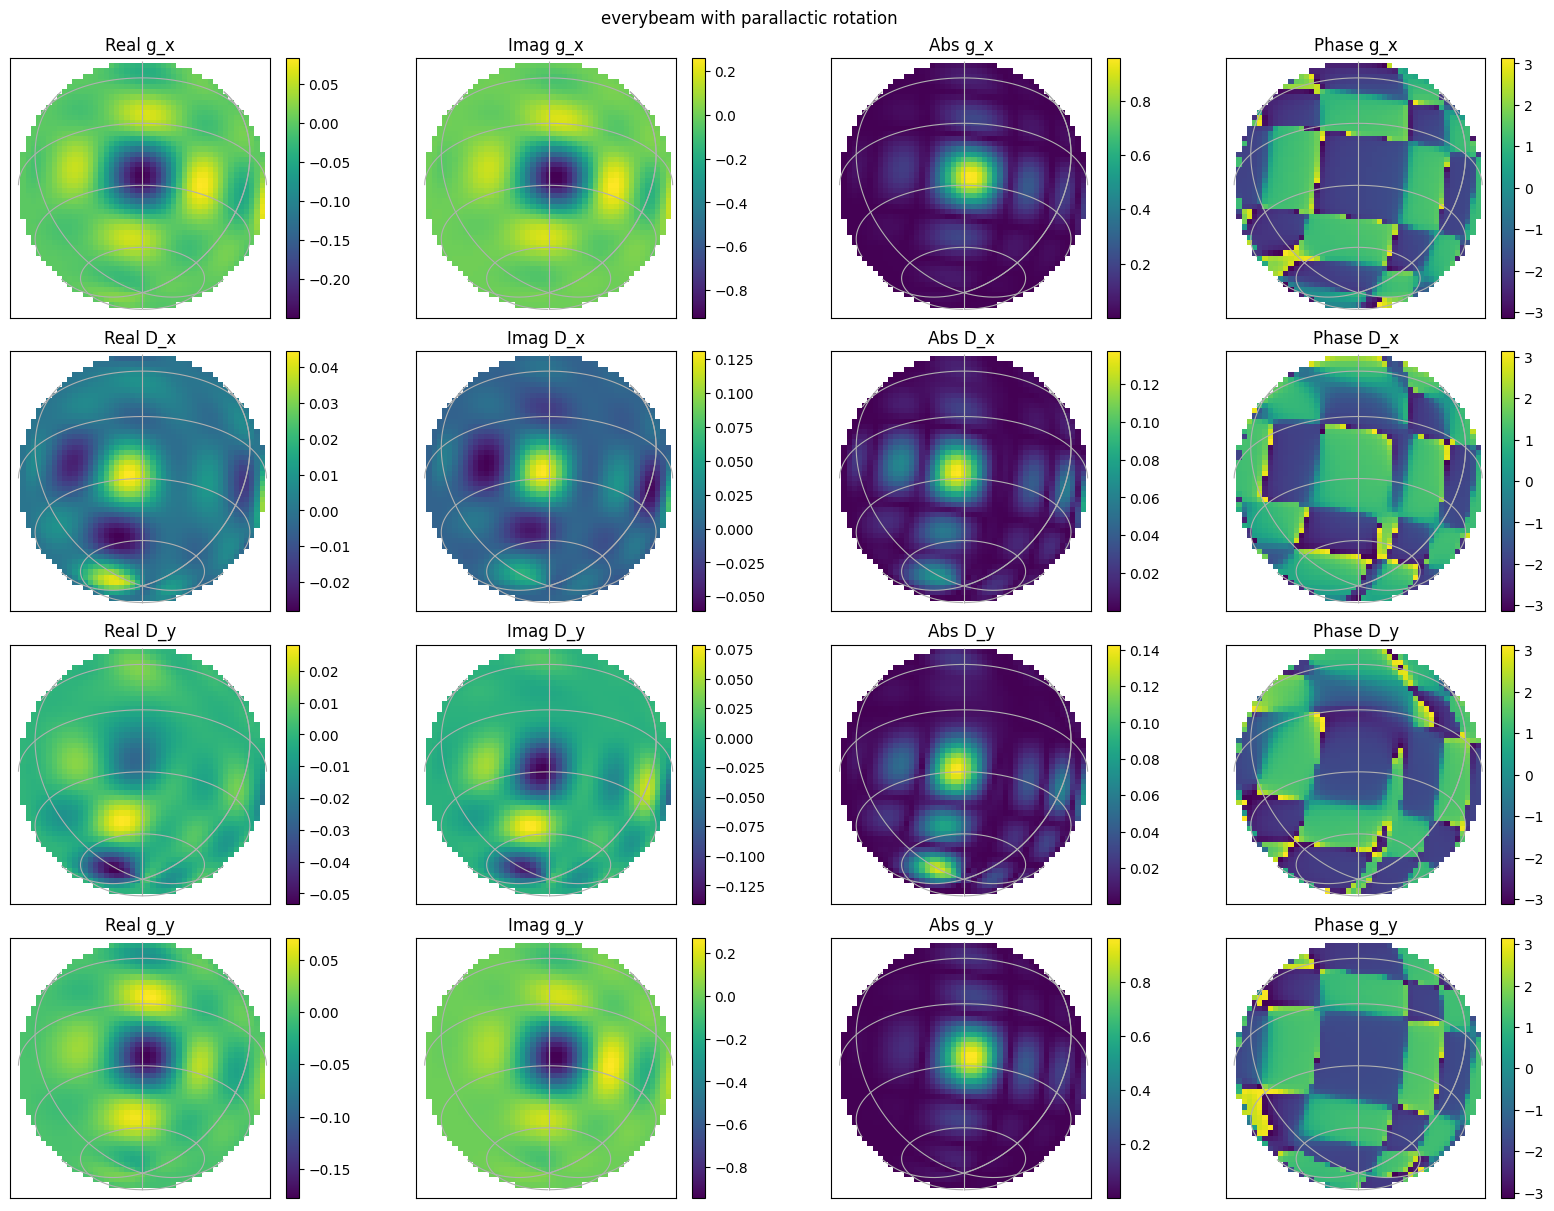

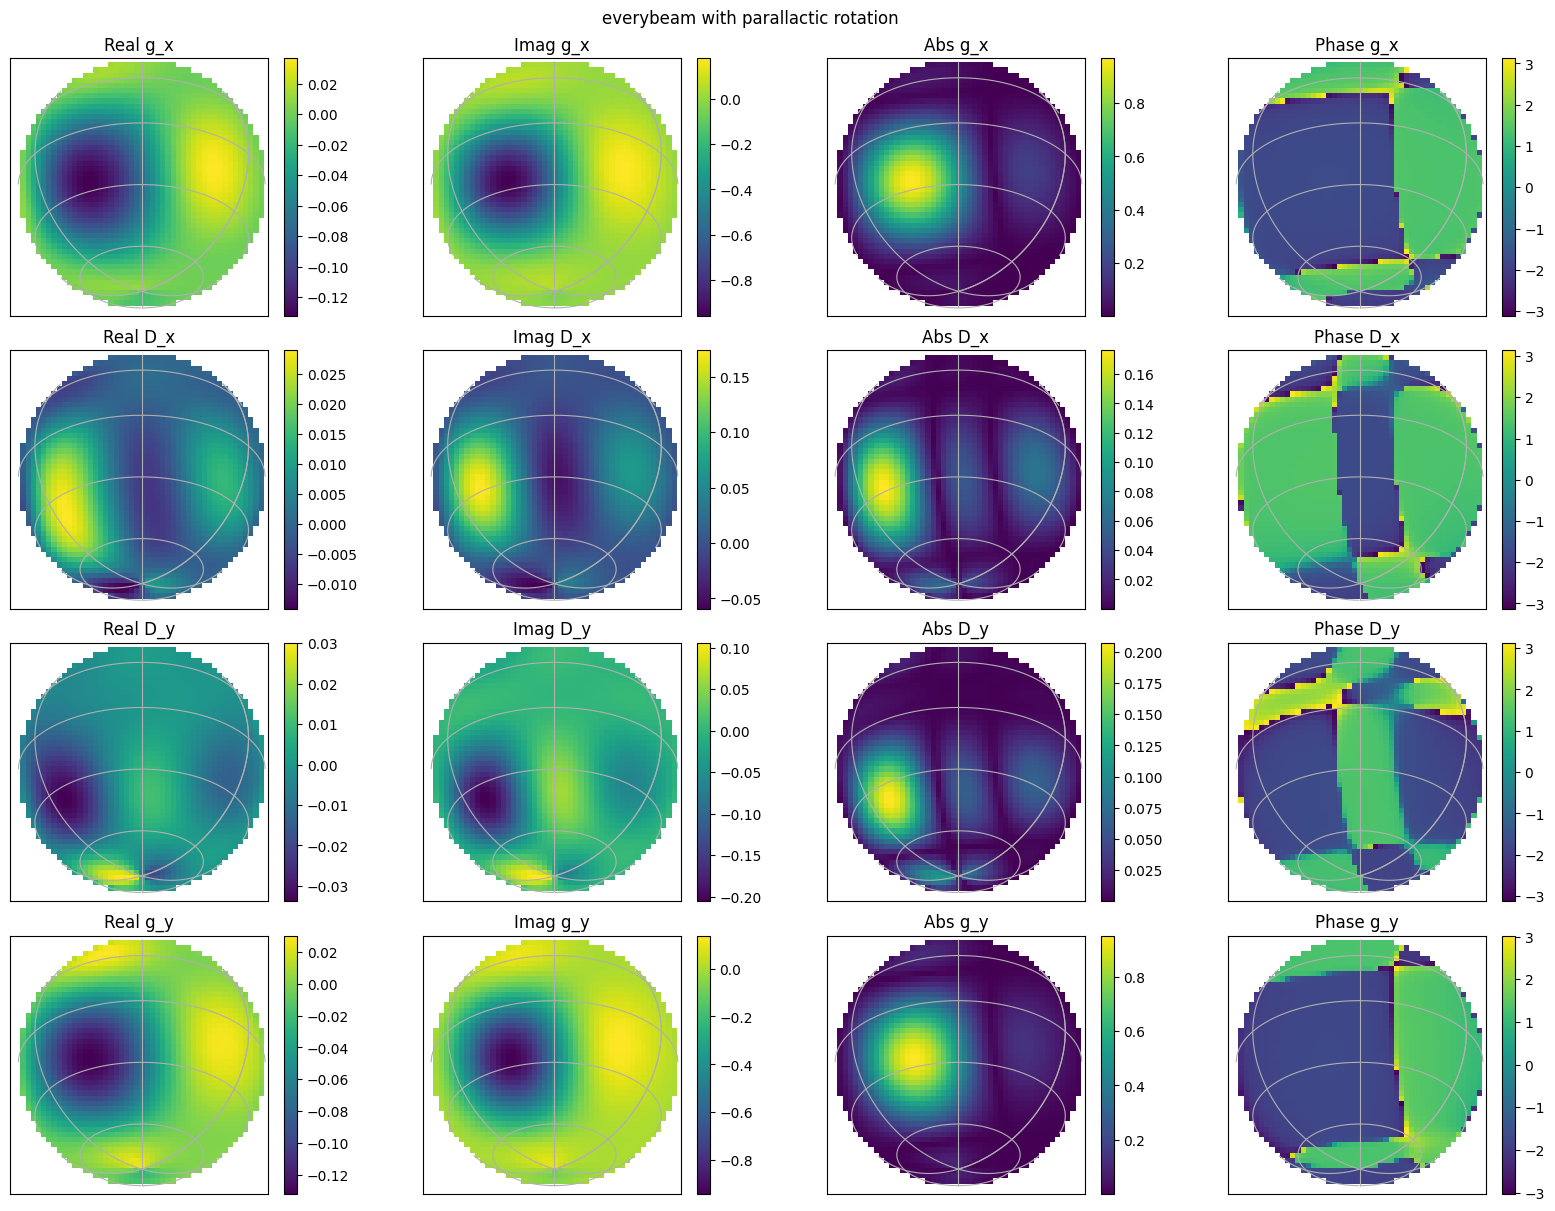

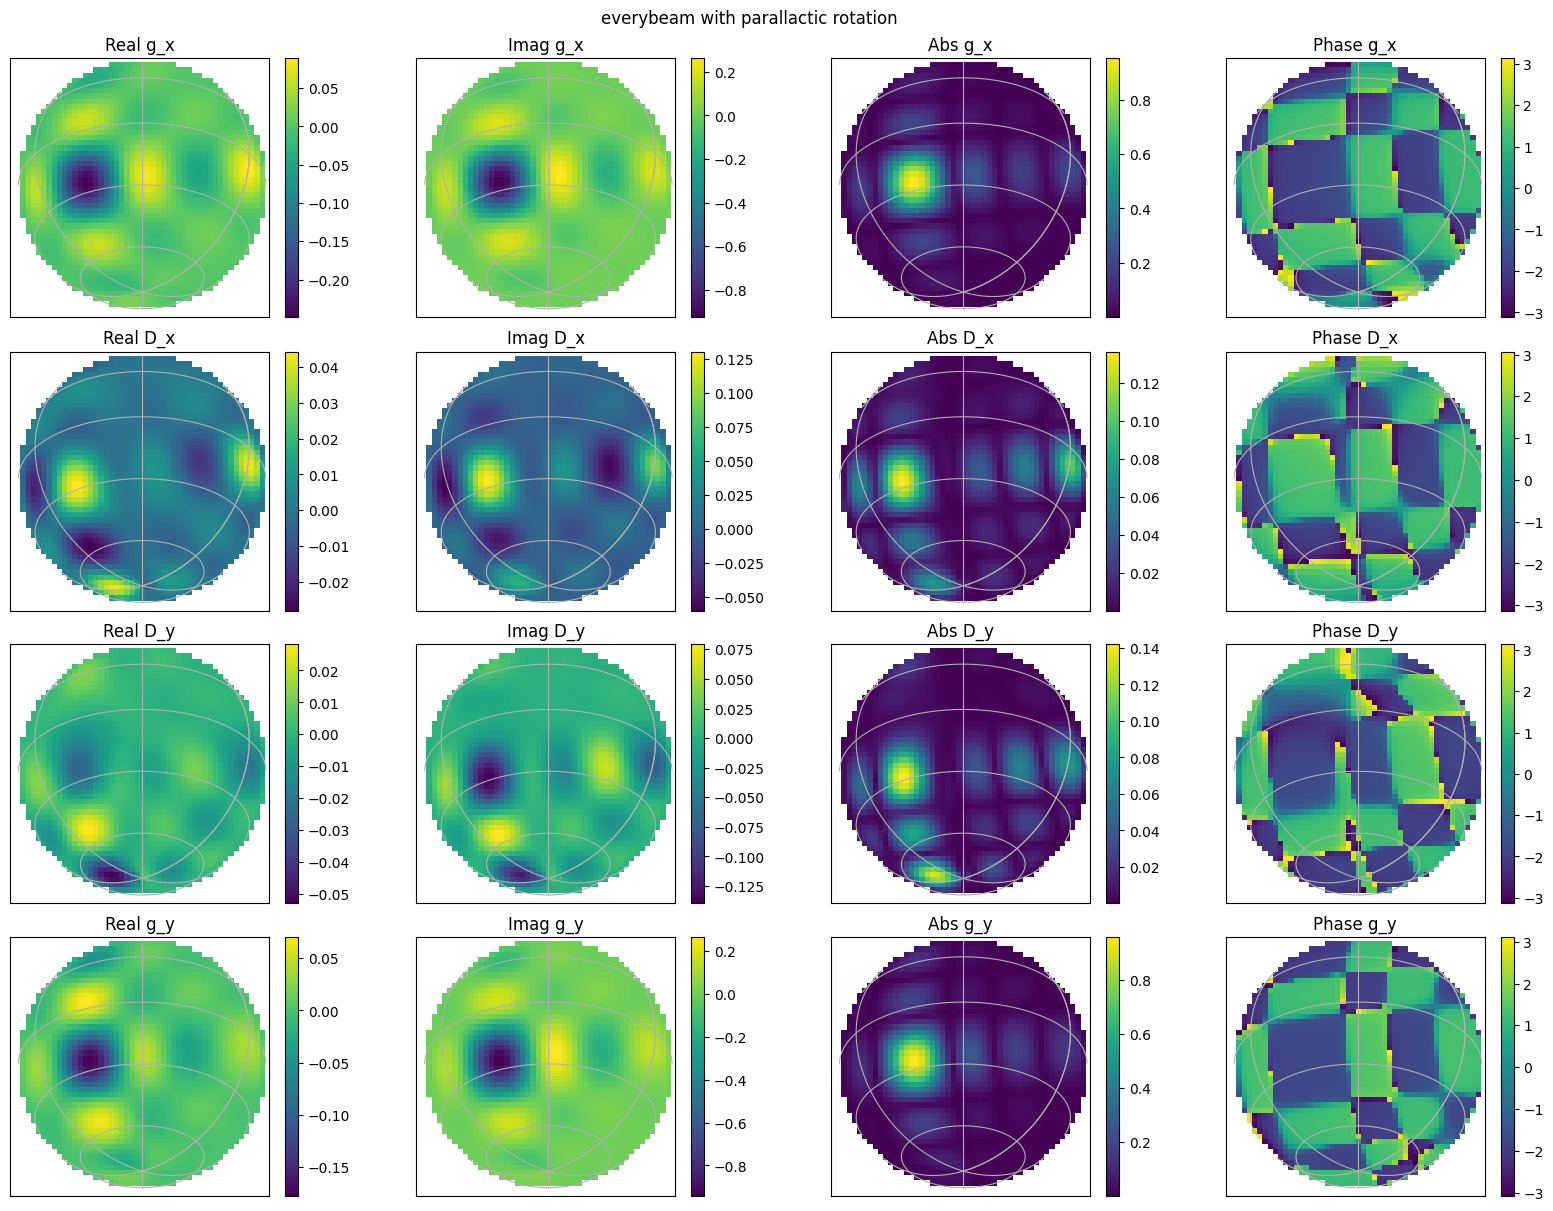

In [33]:
beam_ind = 0

for time_ind in range(len(all_times)):
    for freq_ind in range(len(all_freqs)):
        this_gx = all_jones[beam_ind, time_ind, freq_ind, :, 0, 0]
        this_Dx = all_jones[beam_ind, time_ind, freq_ind, :, 0, 1]
        this_Dy = all_jones[beam_ind, time_ind, freq_ind, :, 1, 0]
        this_gy = all_jones[beam_ind, time_ind, freq_ind, :, 1, 1]

        this_gx.shape = (nside, nside)
        this_Dx.shape = (nside, nside)
        this_Dy.shape = (nside, nside)
        this_gy.shape = (nside, nside)

        plot_jones_on_sky(this_gx, this_Dx, this_Dy, this_gy, wcs, title="everybeam with parallactic rotation")

Double check what it should look like using `hyperdrive`, where we can explicitly put the delays that we want in.

/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


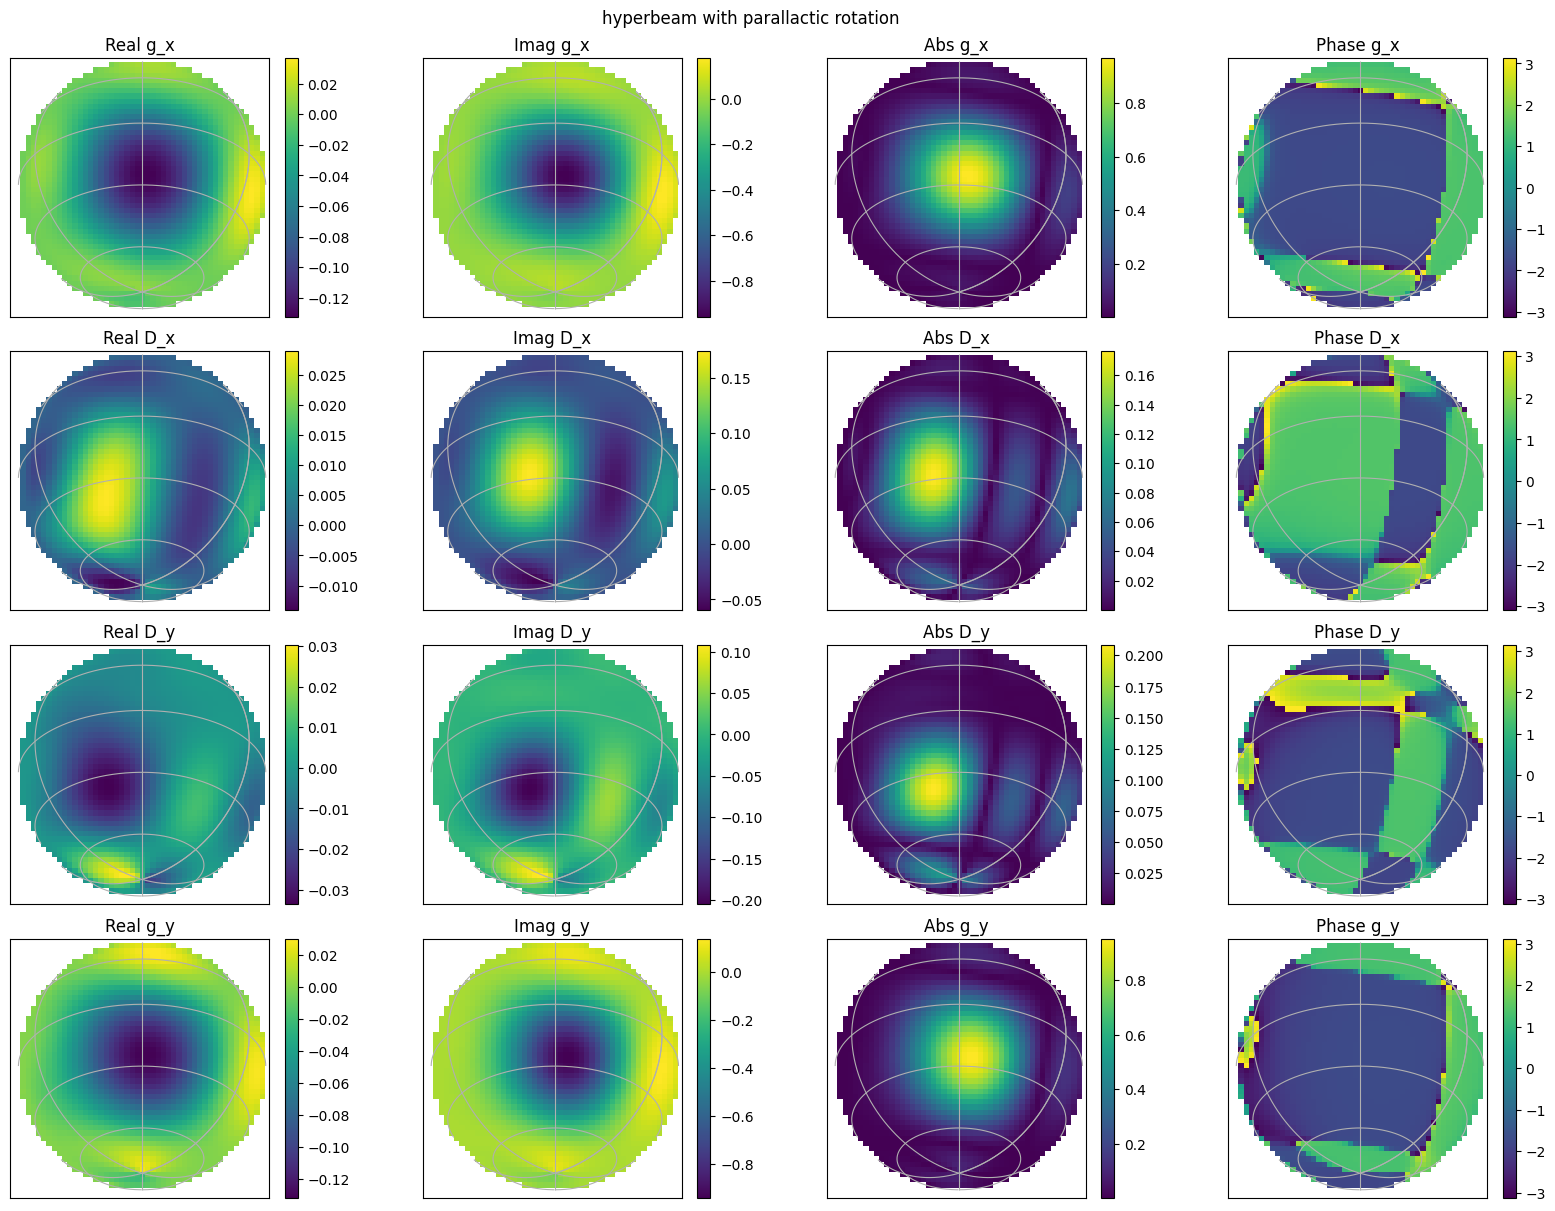

/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


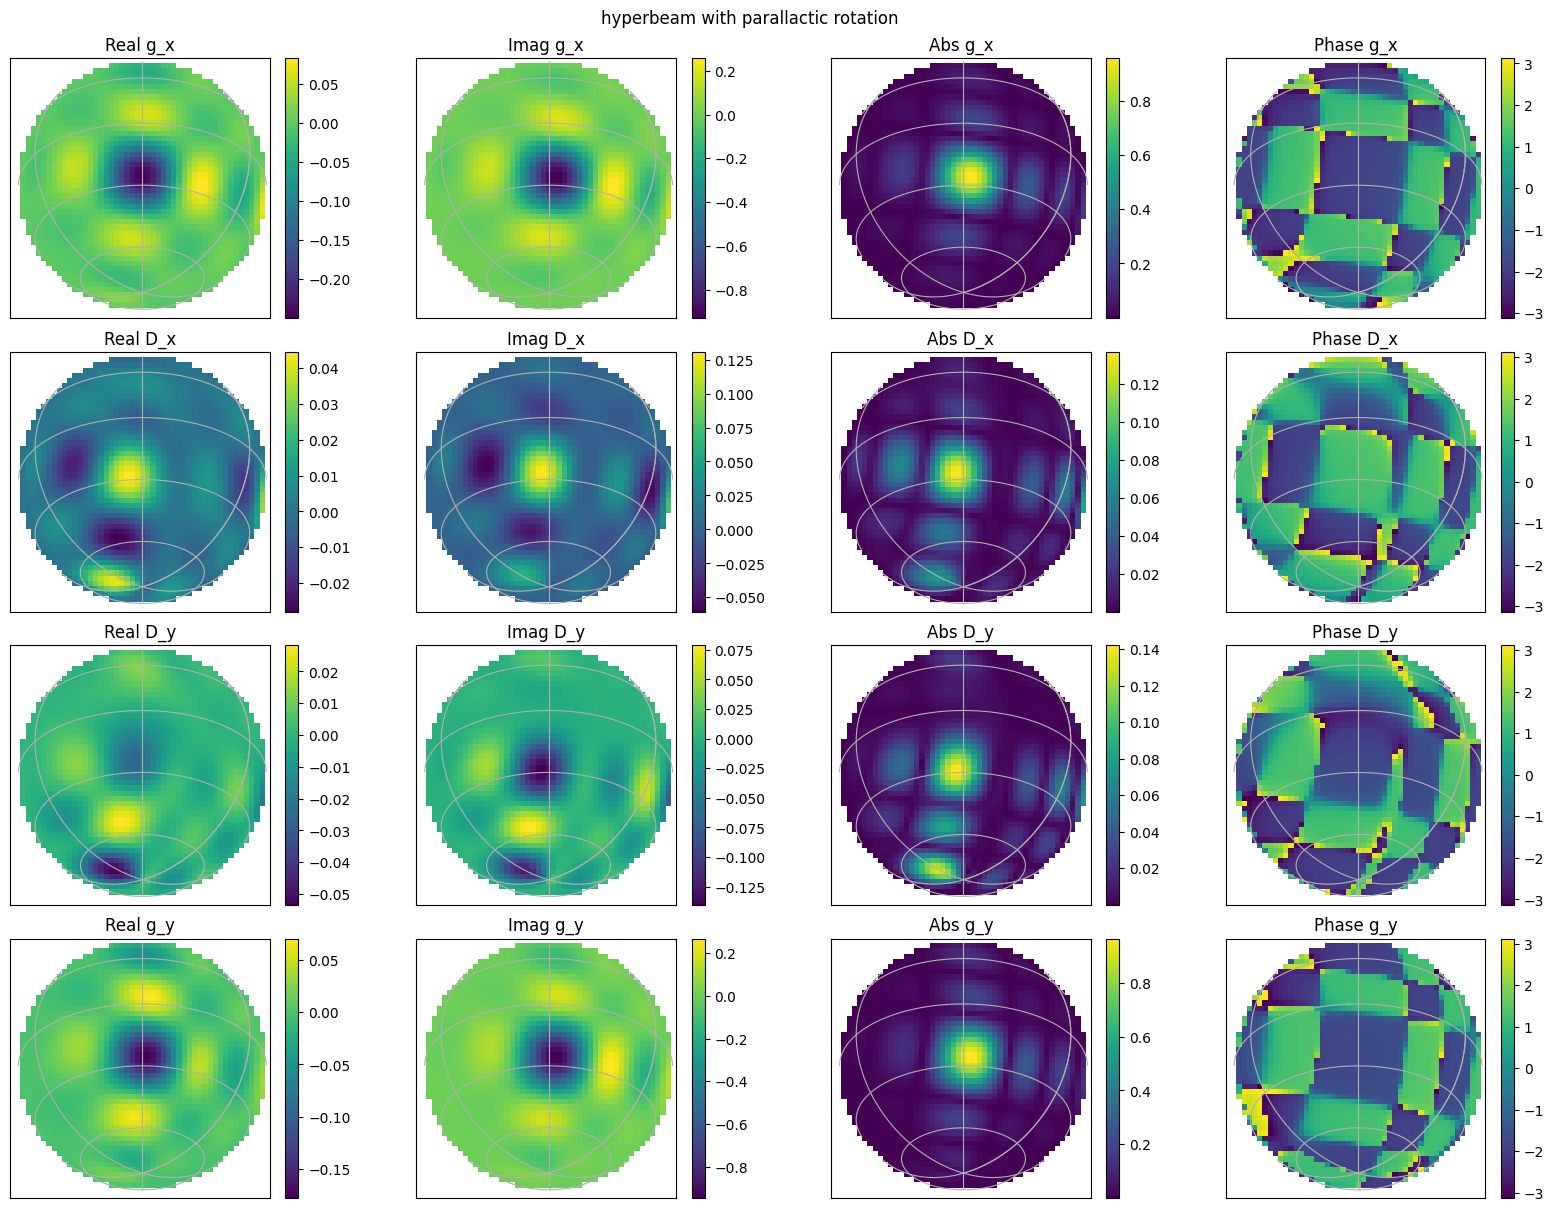

/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


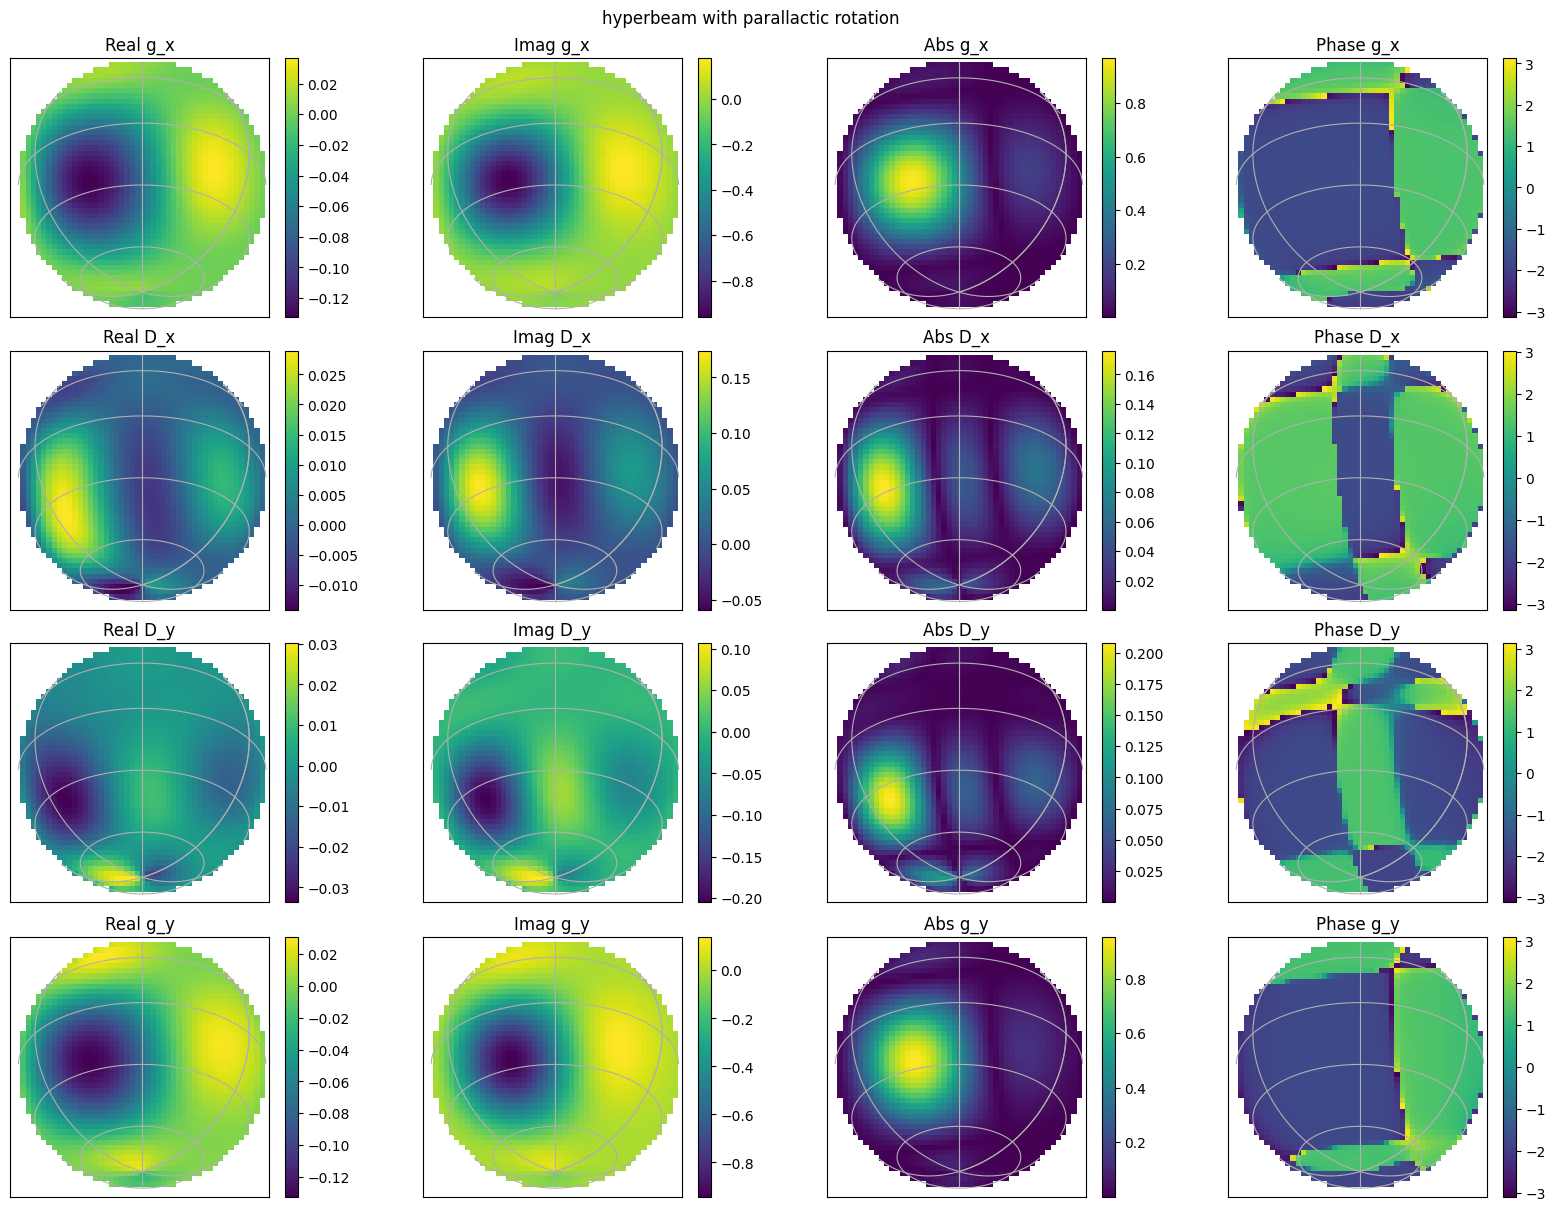

/home/jack-line/software/WODEN_dev/woden_dev/lib/python3.12/site-packages/erfa/core.py:18088: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)


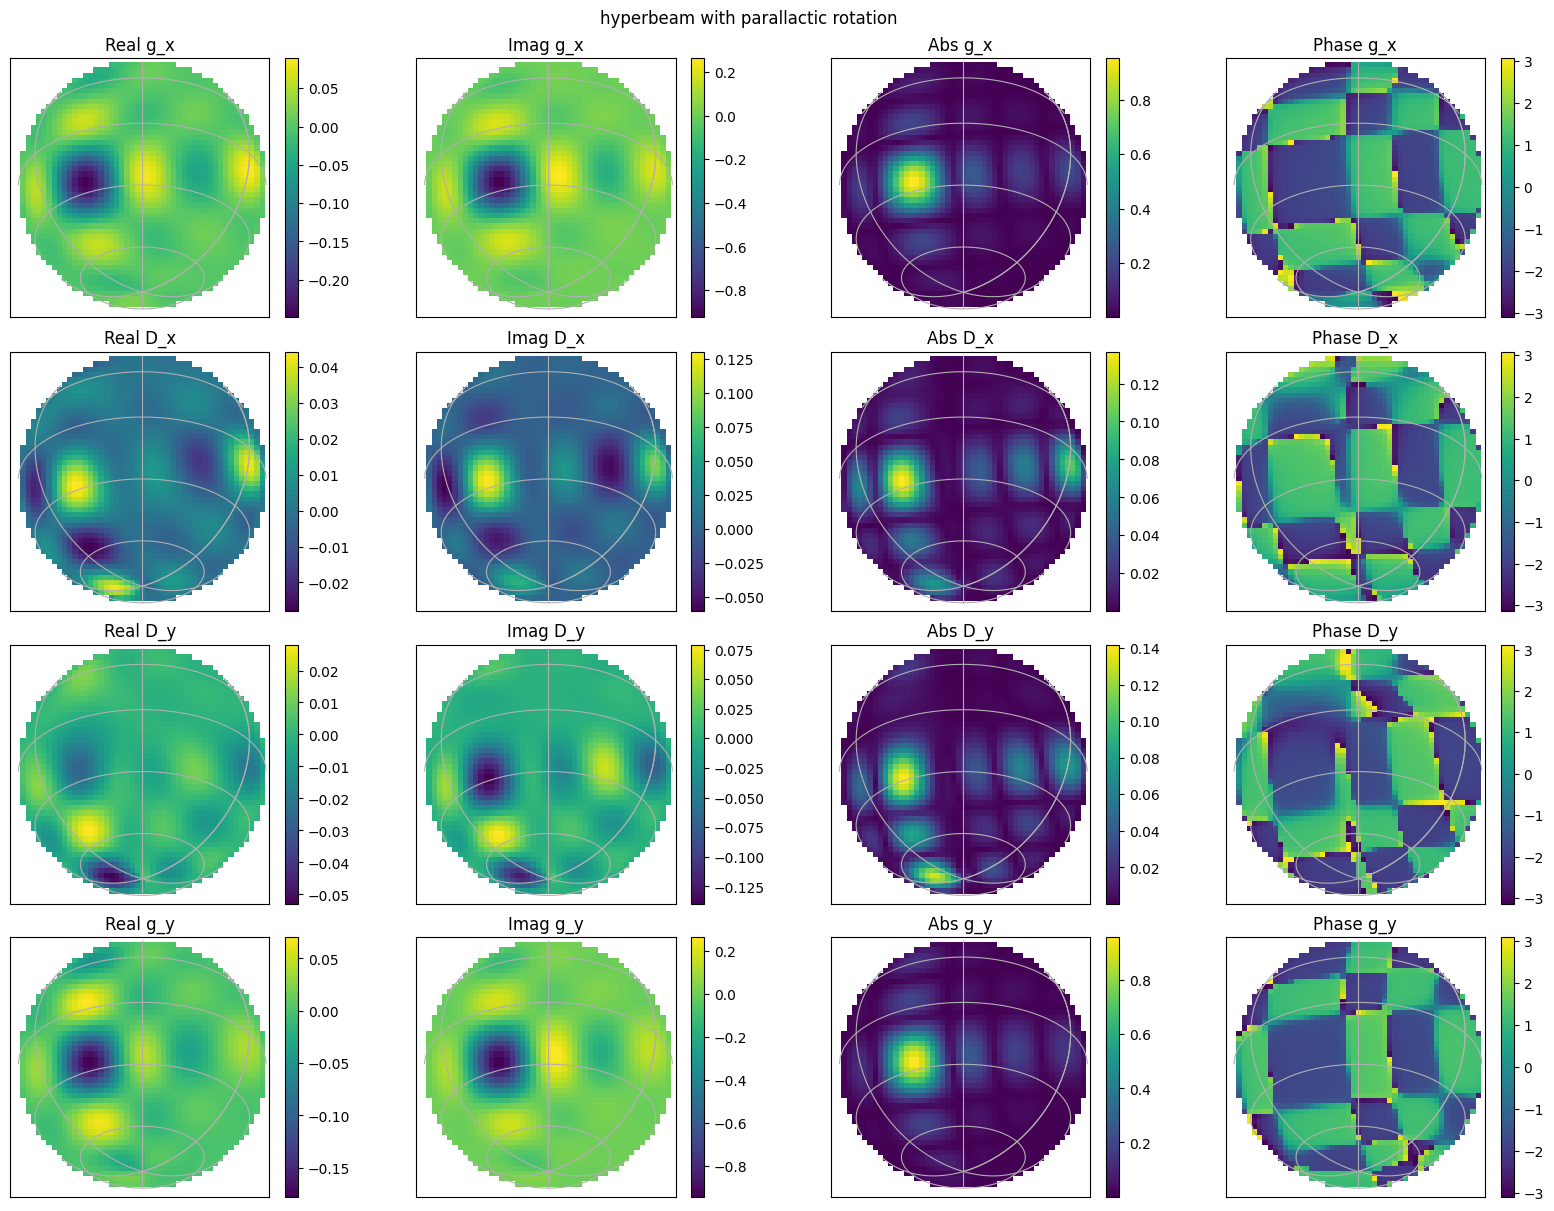

In [34]:
##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here

for this_time in all_times:
    for freq in all_freqs:

        has = np.radians(this_time.sidereal_time('mean').value*15.0) - ras

        az_grid, els = erfa.hd2ae(has, decs, np.radians(MWA_LAT))

        za_grid = np.pi/2 - els

        beam = mwa_hyperbeam.FEEBeam(hdf5_file=os.environ["MWA_FEE_HDF5"])

        parallactic_rotation = True
        delays = [0,2,4,6,0,2,4,6,0,2,4,6,0,2,4,6]

        jones = beam.calc_jones_array(az_grid, za_grid, freq, delays, [1]*16, True, np.radians(MWA_LAT), parallactic_rotation)

        all_gx = jones[:,0]
        all_Dx = jones[:,1]
        all_Dy = jones[:,2]
        all_gy = jones[:,3]

        all_gx.shape = (nside, nside)
        all_Dx.shape = (nside, nside)
        all_Dy.shape = (nside, nside)
        all_gy.shape = (nside, nside)

        plot_jones_on_sky(all_gx, all_Dx, all_Dy, all_gy, wcs, title="hyperbeam with parallactic rotation")

## Interpolated beam
Can we use the interpolated Daniel Ung `.h5` file for highband? Let's try it.

In [35]:

from astropy.table import Column, Table
import numpy as np
import os

sing_ra = 15.0
sing_dec = -40.0

ras = [sing_ra]
decs = [sing_dec]

num_comps = len(ras)

c_ids = Column(data=np.array(['source']*num_comps), name='UNQ_SOURCE_ID', dtype='|S20')
c_names = Column(data=np.array([f'source_C{i:04d}' for i in range(num_comps)]), name='NAME', dtype='|S20')

##Component position
c_ras = Column(data=ras, name='RA')
c_decs = Column(data=decs, name='DEC')

##This says we have a point source
c_comp_types = Column(data=np.array(['P']*num_comps, dtype='|S1'), name="COMP_TYPE", dtype='|S1')
##This says we have a Stokes I power-law SED
c_mod_types = Column(data=np.array(['pl']*num_comps, dtype='|S3'), name="MOD_TYPE", dtype='|S3')

##Set everything as a flat spectrum 1 Jy stokes I source. That way we can image it and see the beam pattern
c_stokes_I_ref = Column(data=np.ones(num_comps), name='NORM_COMP_PL')
c_stokes_I_SI = Column(data=np.zeros(num_comps), name='ALPHA_PL')


cols = [c_ids, c_names, c_ras, c_decs, c_comp_types, c_mod_types, c_stokes_I_ref, c_stokes_I_SI]

main_table = Table(cols)

single_cat = 'single_point.fits'

main_table.write(single_cat, format='fits', overwrite=True)


ra0=0.0
dec0=-26.7
date="2024-07-21T20:13:00"
primary_beam="everybeam_MWA"
num_times=1
num_freq_chans=390
low_freq=167e+6
ms_path="MWA-single-timeslot.ms"
uvfits_name="interp_run_woden"
freq_reso=80e+3

args = []

interp_h5 = os.environ['MWA_FEE_HDF5_INTERP']

cmd = 'run_woden.py '

cmd += f'--ra0={sing_ra} '
cmd += f'--dec0={-sing_dec} '
cmd += f'--metafits_filename=../../examples/metafits/1125949472_metafits.fits '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--beam_ms_path={ms_path} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps={num_times} '
cmd += f'--IAU_order '
cmd += f'--station_id=0 '
cmd += f'--cat_filename={single_cat} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--num_threads=1 '
cmd += f'--hdf5_beam_path={interp_h5} '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table MWA-single-timeslot.ms/ANTENNA: 8 columns, 128 rows
2025-02-27 09:50:57 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:50:57 - INFO - Input arguments after parsing:
                             	Array central latitude: -26.703 deg
                             	Array central long

0

In [36]:
coarse_h5 = os.environ['MWA_FEE_HDF5']

uvfits_name = 'coarse_run_woden'

cmd = 'run_woden.py '

cmd += f'--ra0={sing_ra} '
cmd += f'--dec0={-sing_dec} '
cmd += f'--metafits_filename=../../examples/metafits/1125949472_metafits.fits '
cmd += f'--output_uvfits_prepend={uvfits_name} '
cmd += f'--primary_beam={primary_beam} '
cmd += f'--beam_ms_path={ms_path} '
cmd += f'--freq_res={freq_reso} '
cmd += f'--band_nums=1 '
cmd += f'--num_time_steps={num_times} '
cmd += f'--IAU_order '
cmd += f'--station_id=0 '
cmd += f'--cat_filename={single_cat} '
cmd += f'--lowest_channel_freq={low_freq} '
cmd += f'--num_freq_channels={num_freq_chans} '
cmd += f'--time_res=2 '
cmd += f'--num_threads=1 '
cmd += f'--hdf5_beam_path={coarse_h5} '

call(cmd, shell=True)

/home/jack-line/software/WODEN_dev/woden_dev/bin/run_woden.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  __import__('pkg_resources').require('wodenpy==2.5.0')


Successful readonly open of default-locked table MWA-single-timeslot.ms/ANTENNA: 8 columns, 128 rows
2025-02-27 09:51:04 - INFO - 
                                              )  (              )  
                                  (  (     ( /(  )\ )        ( /(  
                                  )\))(   ')\())(()/(   (    )\()) 
                                 ((_)()\ )((_)\  /(_))  )\  ((_)\  
                                 _(())\_)() ((_)(_))_  ((_)  _((_) 
                                 \ \((_)/ // _ \ |   \ | __|| \| | 
                                  \ \/\/ /| (_) || |) || _| | .` | 
                                   \_/\_/  \___/ |___/ |___||_|\_| 
                                   
                                 You are using wodenpy version/git hash: a43c383
                                 
2025-02-27 09:51:04 - INFO - Input arguments after parsing:
                             	Array central latitude: -26.703 deg
                             	Array central long

0

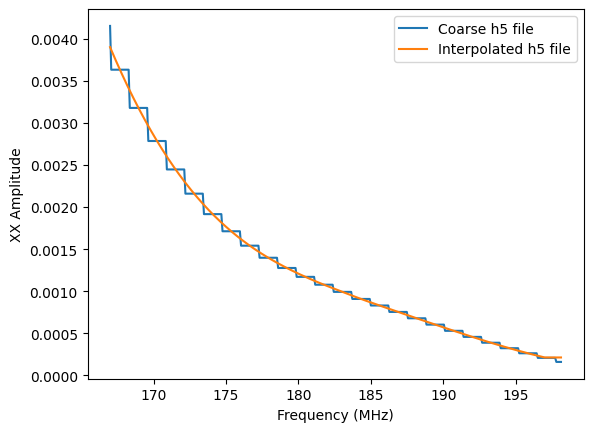

In [37]:
xx_interp, xy_interp, yx_interp, yy_interp = read_uvfits('interp_run_woden_band01.uvfits')
xx_coarse, xy_coarse, yx_coarse, yy_coarse = read_uvfits('coarse_run_woden_band01.uvfits')

freqs = np.arange(low_freq, low_freq + num_freq_chans*freq_reso, freq_reso)

xx_abs = np.abs(xx_coarse[0])
plt.plot(freqs/1e+6, xx_abs, label='Coarse h5 file')

xx_abs = np.abs(xx_interp[0])
plt.plot(freqs/1e+6, xx_abs, label='Interpolated h5 file')
plt.xlabel('Frequency (MHz)')
plt.ylabel('XX Amplitude')
plt.legend()
plt.show()




Yup, seems like we can indeed. It is over 10x slower however. I'm calling `EveryBeam` the exact same number of times, but `EveryBeam` is smart enough to cache repeated values, so the coarse h5 file runs faster.